
=== Multiple File Plotting ===


<Figure size 1920x1440 with 0 Axes>

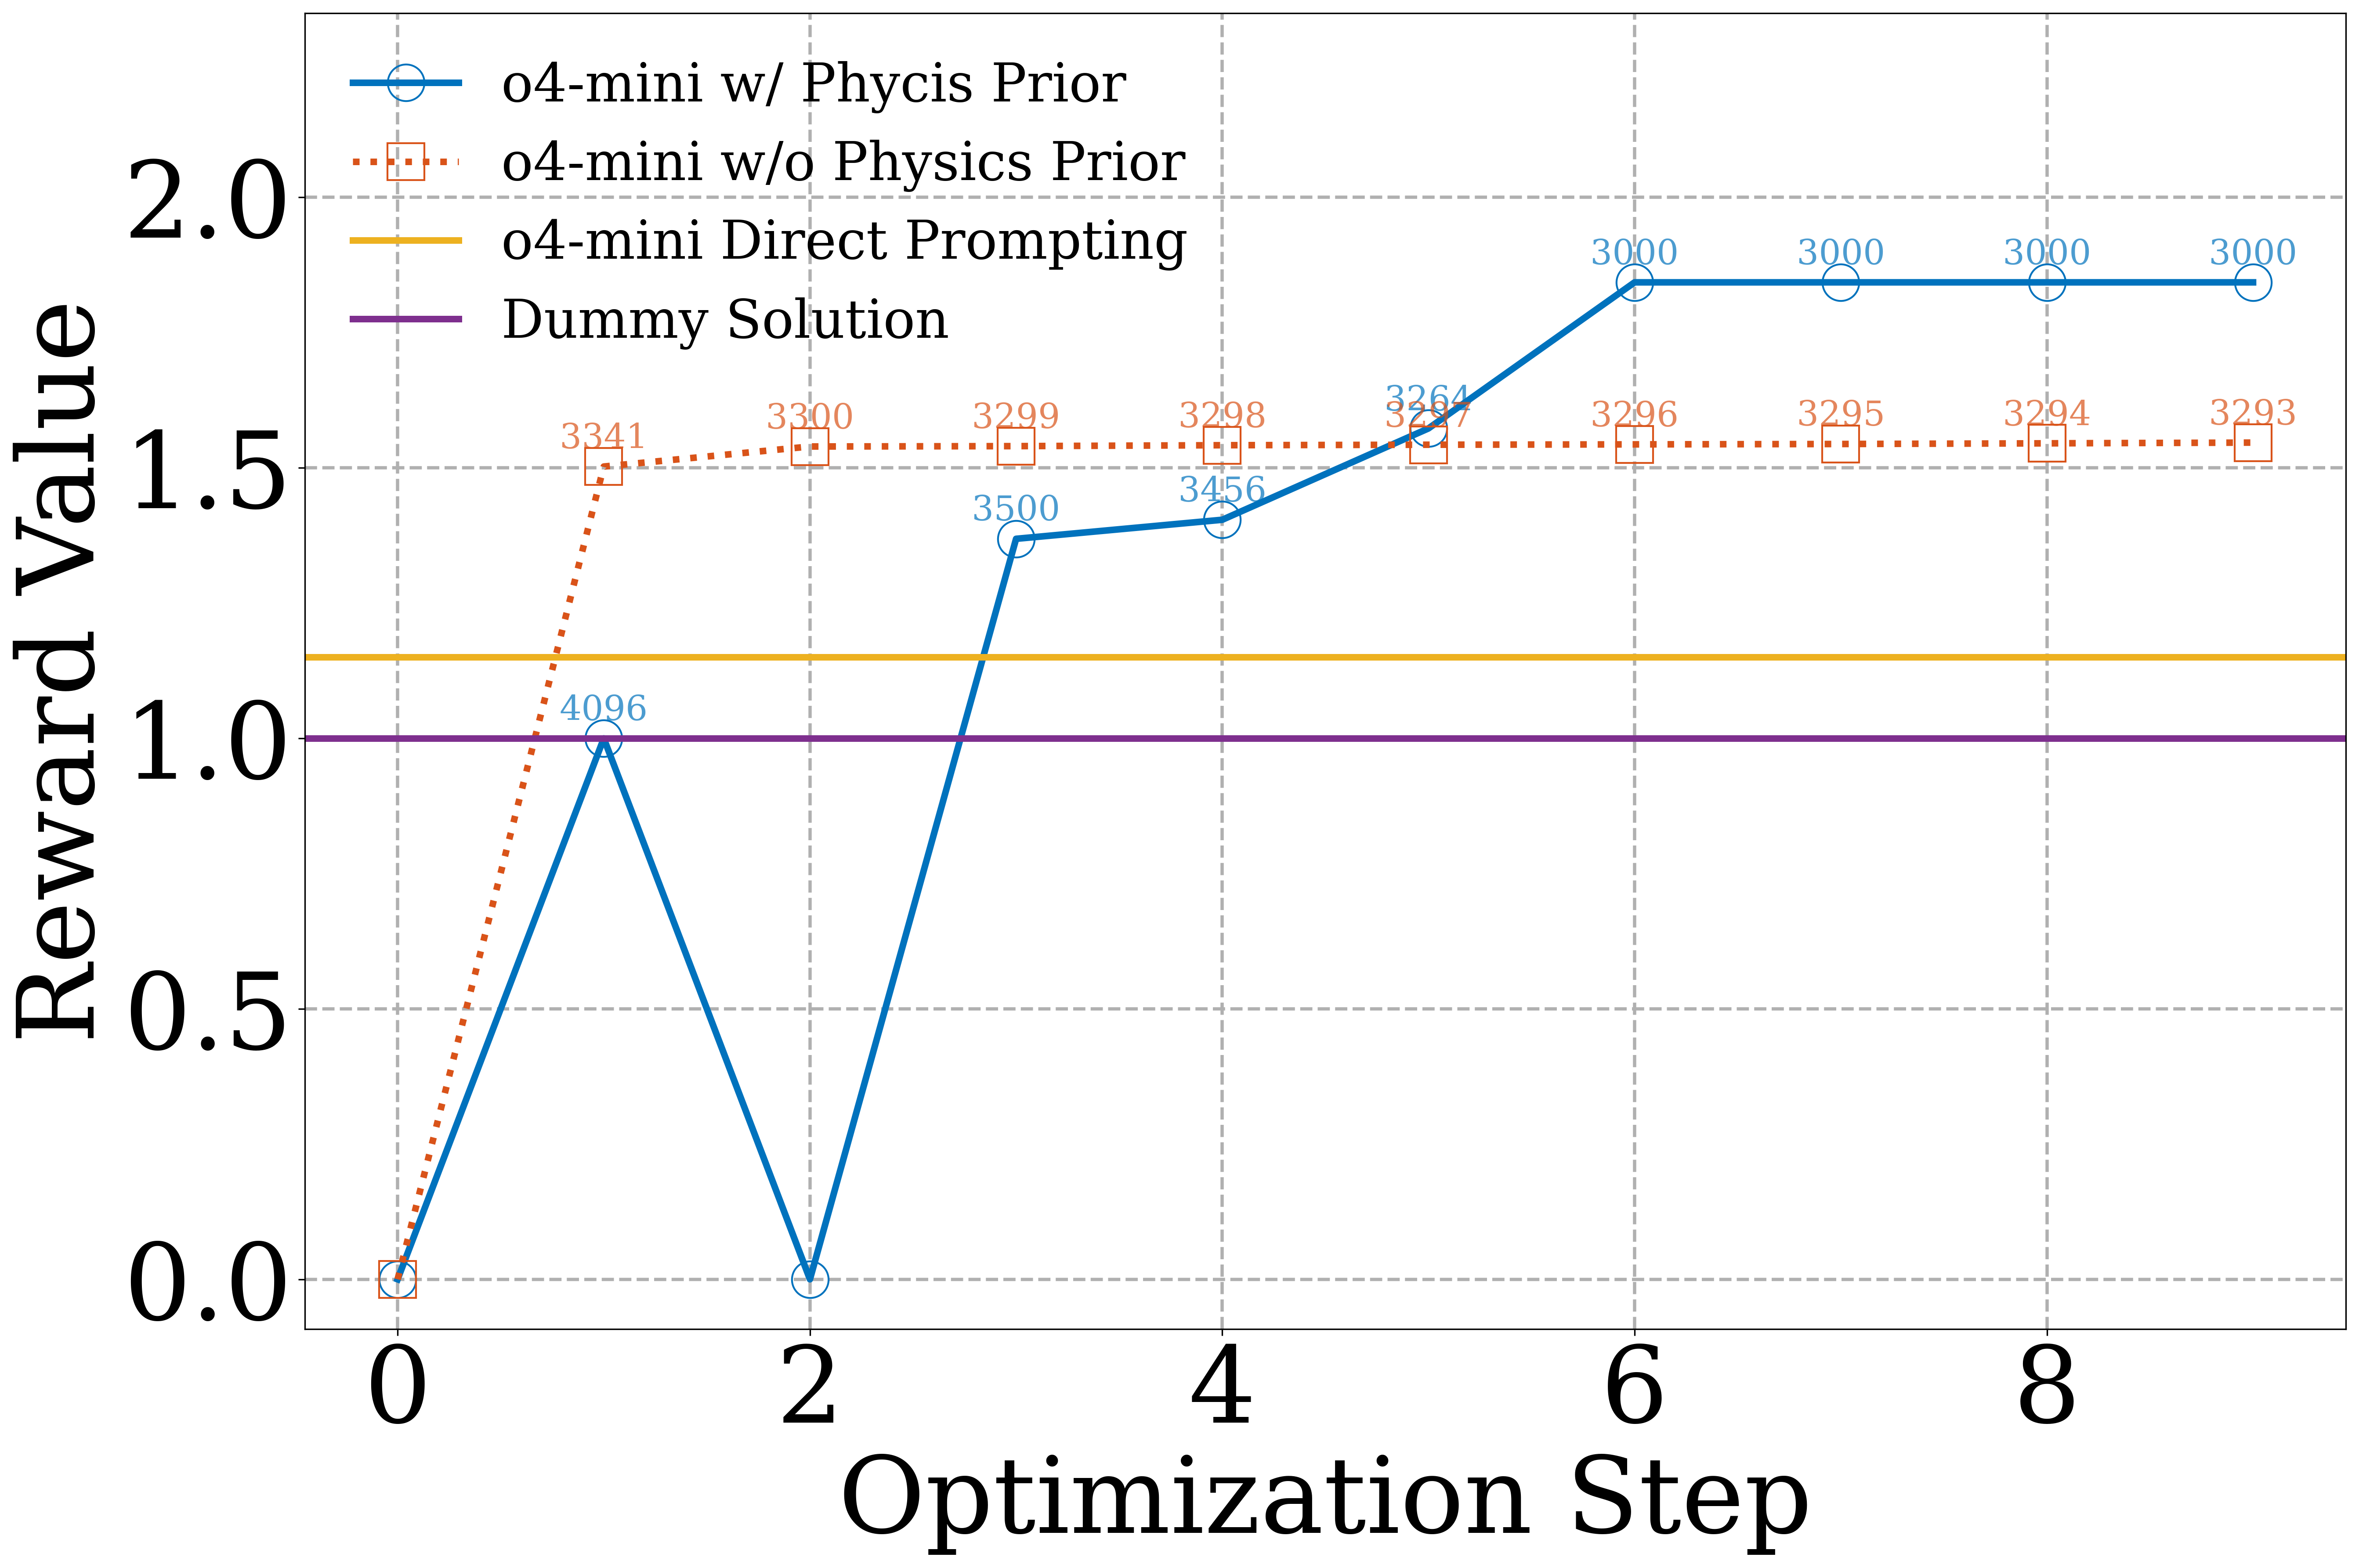

<Figure size 1920x1440 with 0 Axes>

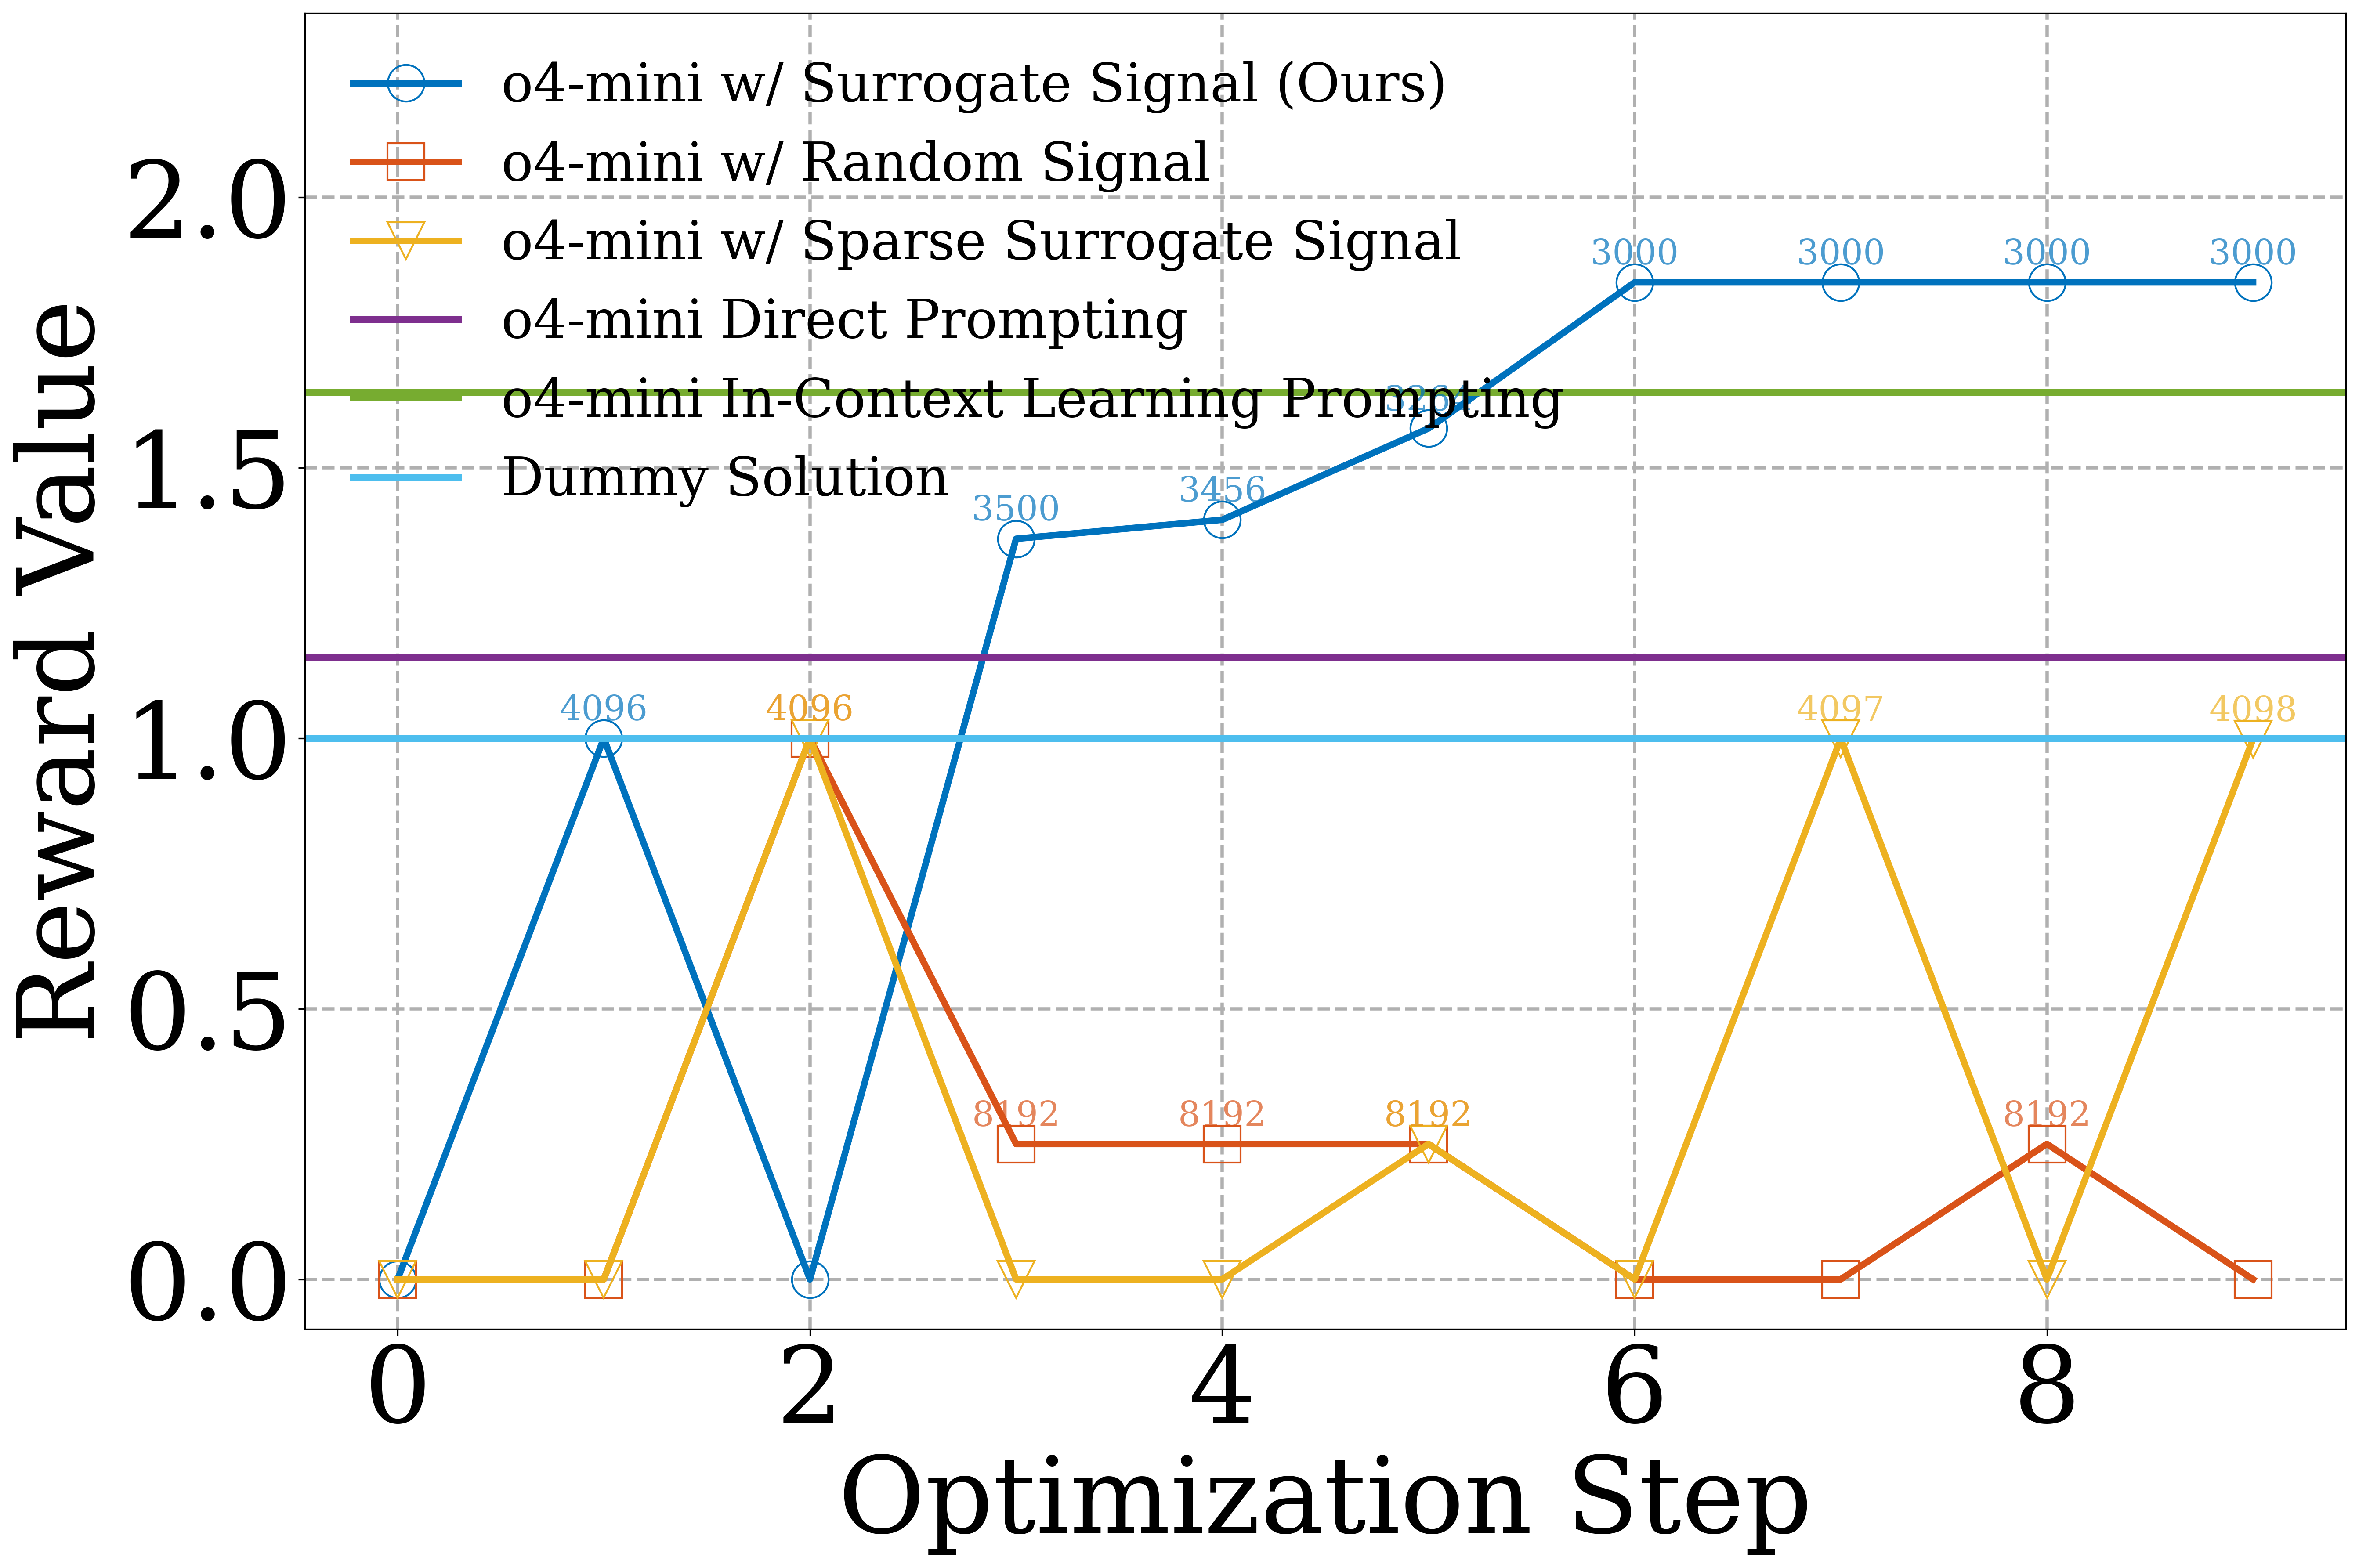


=== Data Structure Verification ===
Extracted data structure:
File 1: 10 steps
  Step 0: real_value=0.0000, n_space=1792
  Step 1: real_value=1.0000, n_space=4096
  Step 2: real_value=0.0000, n_space=128
  Step 3: real_value=1.3689, n_space=3500
  Step 4: real_value=1.4041, n_space=3456
  ... and 5 more steps
File 2: 10 steps
  Step 0: real_value=0.0000, n_space=1400
  Step 1: real_value=1.5025, n_space=3341
  Step 2: real_value=1.5395, n_space=3300
  Step 3: real_value=1.5402, n_space=3299
  Step 4: real_value=1.5419, n_space=3298
  ... and 5 more steps


In [25]:
# Test the new visualization function with multiple files
test_files = [
    "/home/ubuntu/dev/outputs/optimization-results/openai_surrogate_zero-shot/euler_1d-n_space-11-o-o4-mini-2025-09-18-13-15-08.json",
    "/home/ubuntu/dev/outputs/optimization-results/openai_surrogate_numerical-long/euler_1d-n_space-11-o-o4-mini-2025-09-17-11-08-26.json",
    #"/home/ubuntu/dev/outputs/optimization-results/qwen_surrogate/euler_1d-n_space-11-medium-o-local-qwen-2025-09-15-22-18-13.json",
    #"/home/ubuntu/dev/outputs/optimization-results/qwen_surrogate_numerical-long/euler_1d-n_space-11-medium-o-local-qwen-2025-09-16-13-20-29.json"
]

# Example of multiple file plotting (add more files as needed)
print("\n=== Multiple File Plotting ===")
# Uncomment and modify the following lines when you have multiple files to compare:
# multiple_files = [
#     "/home/ubuntu/dev/outputs/optimization-results/openai_surrogate_numerical/1D_heat_transfer-n_space-1-o-o4-mini-2025-09-11-15-31-08.json",
#     "/path/to/another/method/file.json",
#     "/path/to/third/method/file.json"
# ]
# plot_optimization_with_variance(multiple_files, labels=["Method 1", "Method 2", "Method 3"])

# For now, demonstrate with the single file (will show one line)
#plot_optimization_with_variance(test_files, labels=["Random (Random Signal)", "Ours (Surrogate Signal)"], success_threshold=1.0, base=1.5)
plot_optimization_with_variance(test_files,
                                #labels=["o4-mini w/ Phycis Prior", "o4-mini w/o Physics Prior", "Qwen3-8b w/ Physics Prior", "Qwen3-8b w/o Physics Prior"],
                                labels=["o4-mini w/ Phycis Prior", "o4-mini w/o Physics Prior"], 
                                #labels=["Qwen3-8b w/ Physics Prior", "Qwen3-8b w/o Physics Prior"],
                                base_values=[1.15, 1.0],
                                #base_labels=["Qwen3-8b Direct Prompting", "Dummy Solution"],
                                base_labels=["o4-mini Direct Prompting", "Dummy Solution"],
                                name="ab-model-1.pdf")

surrogate_files = [
    "/home/ubuntu/dev/outputs/optimization-results/openai_surrogate_zero-shot/euler_1d-n_space-11-o-o4-mini-2025-09-18-13-15-08.json",
    "/home/ubuntu/dev/outputs/optimization-results/openai_random/euler_1d-n_space-11-medium-o-o4-mini-2025-09-15-11-47-33.json",
    "/home/ubuntu/dev/outputs/optimization-results/openai_hard/euler_1d-n_space-11-o-o4-mini-2025-09-17-22-47-26.json"
]

plot_optimization_with_variance(surrogate_files,
                                labels=["o4-mini w/ Surrogate Signal (Ours)", "o4-mini w/ Random Signal", "o4-mini w/ Sparse Surrogate Signal"],
                                base_values=[1.15, 1.64, 1.0],
                                base_labels=["o4-mini Direct Prompting", "o4-mini In-Context Learning Prompting", "Dummy Solution"],
                                name="ab-surrogate-1.pdf")

# Extract and display data structure for verification
print("\n=== Data Structure Verification ===")
data = extract_optimization_data(test_files)
print("Extracted data structure:")
for i, file_data in enumerate(data):
    print(f"File {i+1}: {len(file_data)} steps")
    for step, real_val, n_space in file_data[:5]:  # Show first 5 steps
        print(f"  Step {step}: real_value={real_val:.4f}, n_space={n_space}")
    if len(file_data) > 5:
        print(f"  ... and {len(file_data)-5} more steps")

In [24]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Union
from pathlib import Path

# MPM-style plotting configuration (reduced font sizes by 2)
paint_res = 300
label_font = 58  # reduced from 60
markersize = 20  # reduced from 36 to 20
tick_font = 58  # reduced from 60
line_width = 3.6
markers = ["o", "s", "v", "D", "h", "H", "d", "*"]
colors = [
    "#0072BD",
    "#D95319",
    "#EDB120",
    "#7E2F8E",
    "#77AC30",
    "#4DBEEE",
    "#A2142F",
    "#000000",
]
# Use serif font that's available on Linux systems
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif", "Times", "Liberation Serif", "serif"]
plt.rcParams["legend.frameon"] = False
plt.rcParams["figure.dpi"] = paint_res
plt.rcParams.update({"figure.autolayout": True})

def extract_optimization_data(filenames: List[str]) -> List[List[Tuple[int, float, int]]]:
    """
    Extract optimization data from JSON files.

    Args:
        filenames: List of JSON file paths

    Returns:
        List of lists, where each inner list contains (step, real_value, n_space) tuples
        for each file, selecting best based on predicted value
    """
    all_file_data = []

    for filename in filenames:
        with open(filename, 'r') as f:
            data = json.load(f)

        if 'old_value_pairs_with_i_step' not in data:
            print(f"Warning: 'old_value_pairs_with_i_step' not found in {filename}")
            continue

        file_step_data = []
        pairs = data['old_value_pairs_with_i_step']

        # Process each step
        for step_key in sorted(pairs.keys(), key=lambda x: int(x) if x != "-1" else -1):
            if step_key == "-1":
                continue

            step_num = int(step_key)
            step_entries = pairs[step_key]

            # Find best entry based on predicted value
            best_entry = None
            best_predicted = float('-inf')

            for entry in step_entries:
                if len(entry) >= 2:
                    # Extract predicted and real values
                    predicted_value = entry[1][-1]  # Last element of predicted values

                    if predicted_value > best_predicted:
                        best_predicted = predicted_value
                        best_entry = entry

            if best_entry is not None:
                # Get real value for the best predicted entry
                real_value = best_entry[-1][-1] if best_entry[-1][0] > 0.9 else 0  # Last element of real values

                # Extract n_space parameter from the params (first element)
                params = best_entry[0]
                n_space = params.get('n_space', 'N/A') if isinstance(params, dict) else 'N/A'

                file_step_data.append((step_num, real_value, n_space))

        all_file_data.append(file_step_data)

    return all_file_data

def plot_optimization_with_variance(filenames: Union[str, List[str]], labels: List[str] = None, success_threshold: float = None, base_values: List[float] = None, base_labels: List[str] = None, name=None):
    """
    Plot optimization results showing real values for entries selected by best predicted values,
    with n_space annotations on the dots. Can handle single file or multiple files.

    Args:
        filenames: Single JSON file path (string) or list of JSON file paths
        labels: Optional labels for each file (defaults to filename)
        success_threshold: Optional success threshold value to draw as red dotted horizontal line
        base_values: Optional list of base model values to draw as horizontal lines
        base_labels: Optional list of labels for base model lines (defaults to 'Base Model 1', 'Base Model 2', etc.)
    """
    # Convert single filename to list for uniform handling
    if isinstance(filenames, str):
        filenames = [filenames]

    if labels is None:
        labels = [Path(f).stem for f in filenames]
    elif len(labels) != len(filenames):
        print(f"Warning: Number of labels ({len(labels)}) doesn't match number of files ({len(filenames)})")
        labels = [Path(f).stem for f in filenames]

    # Handle base_values and base_labels
    if base_values is None:
        base_values = []
    if base_labels is None:
        base_labels = [f'Base Model {i+1}' for i in range(len(base_values))]
    elif len(base_labels) != len(base_values):
        print(f"Warning: Number of base labels ({len(base_labels)}) doesn't match number of base values ({len(base_values)})")
        base_labels = [f'Base Model {i+1}' for i in range(len(base_values))]

    # Extract data
    all_data = extract_optimization_data(filenames)

    # Create figure with MPM-style dimensions (20% taller)
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))

    for i, (file_data, label) in enumerate(zip(all_data, labels)):
        if not file_data:
            print(f"Warning: No data found for {filenames[i]}")
            continue

        steps, real_values, n_spaces = zip(*file_data)

        # Use MPM-style colors and markers
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        # Determine line style based on label name
        linestyle = ':' if 'w/o Physics Prior' in label else '-'

        (ploti,) = ax.plot(steps, real_values,
                          marker=marker,
                          color=color,
                          label=label,
                          linewidth=line_width,  # MPM line width
                          markersize=markersize,  # MPM marker size
                          linestyle=linestyle,
                          fillstyle="none")

        # Add n_space annotations on the dots with matching colors - using MPM font size
        for step, real_val, n_space in file_data:
            if real_val > 0:
                ax.annotate(str(n_space),
                           (step, real_val),
                           textcoords="offset points",
                           xytext=(0,10),
                           ha='center',
                           fontsize=label_font//3,  # Scaled down from MPM label font
                           alpha=0.7,
                           color=color)

    # Add base model lines if provided
    for i, (base_value, base_label) in enumerate(zip(base_values, base_labels)):
        # Use MPM colors for base lines
        base_color = colors[(len(filenames) + i) % len(colors)]
        ax.axhline(y=base_value, color=base_color, linestyle='-',
                  linewidth=line_width, label=base_label)

    # Add success threshold line if provided
    if success_threshold is not None:
        ax.axhline(y=success_threshold, color='red', linestyle=':',
                  linewidth=line_width, alpha=0.8, label=f'Dummy Solution')

    # Apply MPM-style formatting
    ax.tick_params(
        top=False,
        bottom=True,
        left=True,
        right=False,
        labelleft=True,
        labelsize=tick_font,
    )
    ax.xaxis.offsetText.set_fontsize(label_font)
    ax.get_xaxis().set_visible(True)
    ax.set_xlabel('Optimization Step', fontsize=label_font)
    ax.set_ylabel('Reward Value', fontsize=label_font)
    ax.grid(True, linestyle="--", linewidth=line_width / 2)

    # Use original y-axis limits (minimal expansion, just for legend space)
    current_ylim = ax.get_ylim()
    y_range = current_ylim[1] - current_ylim[0]
    ax.set_ylim(current_ylim[0], current_ylim[1] + y_range * 0.2)  # Add only 20% more space at top

    # MPM-style legend
    ax.legend(loc='best', fontsize=label_font//2)

    # Save with MPM settings
    plt.savefig(name, transparent=False, dpi=300, bbox_inches="tight", format="pdf")
    plt.show()

# Example usage for single file:
# plot_optimization_with_variance("/path/to/file.json")

# Example usage for multiple files:
# filenames = [
#     "/home/ubuntu/dev/outputs/optimization-results/openai_surrogate_numerical/1D_heat_transfer-n_space-1-o-o4-mini-2025-09-11-15-31-08.json",
#     "/path/to/another/file.json",
#     "/path/to/third/file.json"
# ]
# plot_optimization_with_variance(filenames, labels=["Method 1", "Method 2", "Method 3"], success_threshold=0.8, base_values=[0.5, 0.7], base_labels=["GPT-4o", "Claude-3.5"])

In [ ]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def plot_optimization_results(names, base_path="/home/ubuntu/dev/outputs/optimization-results"):
    """
    Plot optimization results for multiple methods.
    
    Args:
        names: List of folder names under base_path
        base_path: Base directory containing optimization results
    """
    plt.figure(figsize=(10, 6))
    
    for name in names:
        folder_path = Path(base_path) / name
        
        # Find log files in the folder
        log_files = list(folder_path.glob("*.json"))
        
        if not log_files:
            print(f"No log files found in {folder_path}")
            continue
            
        # Use the first log file found
        log_file = log_files[0]
        
        with open(log_file, 'r') as f:
            data = json.load(f)
        
        if 'old_value_pairs_with_i_step' not in data:
            print(f"'old_value_pairs_with_i_step' key not found in {log_file}")
            continue
        
        steps = []
        best_real_values = []
        
        pairs = data['old_value_pairs_with_i_step']
        
        
        # Process each step
        for step in pairs:
            if step == "-1":
                continue
            points = pairs[step]
    
            ranked_points = sorted(points, key=lambda x: (-x[1][0], -x[1][1]))
            best_real_values.append(int(ranked_points[0][2][0] >= 1.0) * ranked_points[0][2][1])
            steps.append(step)
            '''for point in points:
                if len(point) >= 3:
                    params, pred_values, real_values = point[0], point[1], point[2]
                    score = pred_values[2] if len(pred_values) > 2 else float('-inf')
                    
                    if score > best_score:
                        best_score = score
                        best_point = point
            
            if best_point is not None:
                real_value = best_point[2][2] if len(best_point[2]) > 2 else 0
                steps.append(step_num)
                best_real_values.append(real_value)'''
        
        # Plot the line for this method
        if steps and best_real_values:
            plt.plot(steps, best_real_values, marker='o', label=name, linewidth=2, markersize=6)
        else:
            print(f"No valid data points found for {name}")
                
    
    plt.xlabel('Step', fontsize=18)  # Increased from 14 to 18
    plt.ylabel('Real Value', fontsize=18)  # Increased from 14 to 18
    plt.title('Optimization Progress: Best Real Value per Step', fontsize=20)  # Increased from 16 to 20
    plt.legend(fontsize=14)  # Increased from 10 to 14
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=14)  # Increased from 10 to 14
    plt.yticks(fontsize=14)  # Increased from 10 to 14
    sns.despine()
    plt.tight_layout()
    plt.show()

# Example usage:
# names = ['openai_eg_max', 'openai_eg_few', 'another_method']
# plot_optimization_results(names)

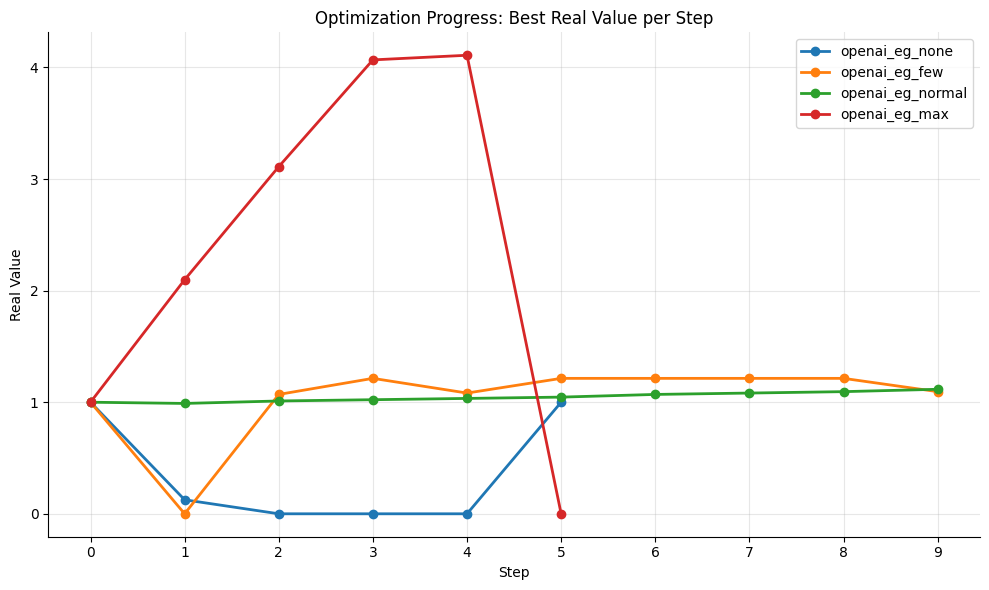

In [23]:
names = ['openai_eg_none', 'openai_eg_few', 'openai_eg_normal', 'openai_eg_max']
plot_optimization_results(names)

In [12]:
import re
import json
import ast
from typing import List, Tuple, Dict

def extract_tool_call_data(file_paths: List[str]) -> List[List[Tuple[str, float, int]]]:
    """
    Extract tool call data from log files.
    
    Args:
        file_paths: List of log file paths
        
    Returns:
        List of lists, where each inner list contains (tool_args, RMSE, accumulated_cost) tuples for each QID
    """
    all_qid_data = []
    
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            content = f.read()
        
        # Detect file format and extract accordingly
        if '🆔 QID:' in content and '📉 RMSE (model vs. dummy):' in content:
            # Evaluation results format
            qid_data = extract_evaluation_format(content)
        else:
            # Tool call log format
            qid_data = extract_tool_call_format(content)
        
        all_qid_data.extend(qid_data)
    
    return all_qid_data

def extract_evaluation_format(content: str) -> List[List[Tuple[str, float, int]]]:
    """Extract data from evaluation results format."""
    qid_blocks = re.split(r'📊 --- Evaluation Result ---', content)
    qid_data = []
    
    for block in qid_blocks[1:]:  # Skip first empty block
        # Extract QID
        qid_match = re.search(r'🆔 QID:\s*(\d+)', block)
        if not qid_match:
            continue
            
        # Extract RMSE
        rmse_match = re.search(r'📉 RMSE \(model vs\. dummy\):\s*([0-9.e-]+)', block)
        rmse = float(rmse_match.group(1)) if rmse_match else 0.0
        
        # Extract Model Cost
        cost_match = re.search(r'💰 Model Cost:\s*(\d+)', block)
        cost = int(cost_match.group(1)) if cost_match else 0
        
        # Extract Model Parameters
        param_match = re.search(r'📌 Model Parameters:\s*\{([^}]*)\}', block, re.DOTALL)
        if param_match:
            param_str = '{' + param_match.group(1) + '}'
            # Clean up the parameter string format
            param_str = re.sub(r'\s*"([^"]+)":\s*([^,\n}]+)', r'"\1": \2', param_str)
            tool_args = param_str
        else:
            tool_args = "N/A"
        
        # Each evaluation result represents a single "step" for this QID
        qid_data.append([(tool_args, rmse, cost)])
    
    return qid_data

def extract_tool_call_format(content: str) -> List[List[Tuple[str, float, int]]]:
    """Extract data from tool call log format."""
    qid_data = []
    
    # Split by QID sections
    qid_sections = re.split(r'========== 🧐 The model begins to solve a new problem ==========', content)
    
    for section in qid_sections[1:]:  # Skip first empty section
        qid_tool_calls = []
        
        # Find all tool calls and their results in this QID using a more flexible approach
        # Split by tool call blocks
        tool_call_blocks = re.findall(
            r'QID=(\d+) - 🛠 Received tool call: \{(.*?)\}(?=\n\[INFO|\nQID|\Z)', 
            section, 
            re.DOTALL
        )
        
        # Find RMSE and accumulated_cost from results
        result_blocks = re.findall(
            r'QID=\d+ - ✅ Tool call result: \{(.*?)\}(?=\n\[INFO|\nQID|\Z)', 
            section, 
            re.DOTALL
        )
        
        # Process each tool call block
        for i, (qid, tool_call_content) in enumerate(tool_call_blocks):
            if i < len(result_blocks):
                result_content = result_blocks[i]
                
                # Extract RMSE
                rmse_match = re.search(r'"RMSE":\s*([0-9.]+)', result_content)
                rmse = float(rmse_match.group(1)) if rmse_match else 0.0
                
                # Extract accumulated_cost
                cost_match = re.search(r'"accumulated_cost":\s*([0-9]+)', result_content)
                accumulated_cost = int(cost_match.group(1)) if cost_match else 0
                
                # Extract tool_args - handle both string and JSON object formats
                tool_args = "N/A"  # Default value
                
                # Try to find tool_args as a string (format 1)
                string_match = re.search(r'"tool_args":\s*"([^"]*)"', tool_call_content)
                if string_match:
                    tool_args = string_match.group(1)
                else:
                    # Try to find tool_args as a JSON object (format 2)
                    json_match = re.search(r'"tool_args":\s*(\{[^}]*\})', tool_call_content)
                    if json_match:
                        tool_args = json_match.group(1)
                
                qid_tool_calls.append((tool_args, rmse, accumulated_cost))
        
        if qid_tool_calls:
            qid_data.append(qid_tool_calls)
    
    return qid_data

def compute_mean_rmse_per_step(qid_data: List[List[Tuple[str, float, int]]]) -> List[float]:
    """
    Compute mean RMSE for each step across all QIDs.
    
    Args:
        qid_data: List of lists containing (tool_args, RMSE, accumulated_cost) tuples for each QID
        
    Returns:
        List where i-th element is mean RMSE of all i-th steps
    """
    if not qid_data:
        return []
    
    max_steps = max(len(qid_calls) for qid_calls in qid_data)
    mean_rmse_per_step = []
    
    for step in range(max_steps):
        step_rmse_values = []
        for qid_calls in qid_data:
            if step < len(qid_calls):
                step_rmse_values.append(qid_calls[step][1])  # Get RMSE value
        
        if step_rmse_values:
            mean_rmse_per_step.append(sum(step_rmse_values) / len(step_rmse_values))
    
    return mean_rmse_per_step

def plot_ablation_study_for_qid(file_paths: List[str], qid: int, labels: List[str] = None, metric: str = "rmse"):
    """
    Create ablation study visualization for a specific QID across different methods.
    
    Args:
        file_paths: List of log file paths (each representing a different method)
        qid: QID number to plot (1-indexed)
        labels: Optional labels for each method (defaults to filename)
        metric: Which metric to plot ("rmse" or "cost")
    """
    if labels is None:
        labels = [Path(fp).stem for fp in file_paths]
    
    plt.figure(figsize=(12, 8))
    
    for file_idx, file_path in enumerate(file_paths):
        # Extract data for this file
        qid_data = extract_tool_call_data([file_path])
        
        # Check if the requested QID exists (convert to 0-indexed)
        qid_idx = qid - 1
        if qid_idx < len(qid_data) and qid_data[qid_idx]:
            qid_calls = qid_data[qid_idx]
            steps = list(range(1, len(qid_calls) + 1))
            
            if metric.lower() == "rmse":
                values = [rmse for _, rmse, _ in qid_calls]
                ylabel = "RMSE"
            elif metric.lower() == "cost":
                values = [cost for _, _, cost in qid_calls]
                ylabel = "Accumulated Cost"
            else:
                raise ValueError(f"Unknown metric: {metric}. Use 'rmse' or 'cost'")
            
            print(f"Found {len(qid_calls)} steps for QID {qid} in {Path(file_path).name}")
            print(f"  Data sample: {qid_calls[0] if qid_calls else 'No data'}")
            
            sns.lineplot(x=steps, y=values, marker='o', 
                       label=labels[file_idx], linewidth=2, markersize=6)
        else:
            print(f"Warning: QID {qid} not found in {file_path} (found {len(qid_data)} QIDs total)")
    
    plt.xlabel('Step Number', fontsize=18)  # Increased from 14 to 18
    plt.ylabel(ylabel, fontsize=18)  # Increased from 14 to 18
    plt.title(f'Ablation Study: {ylabel} per Step for QID {qid}', fontsize=20)  # Increased from 16 to 20
    plt.legend(fontsize=14)  # Increased from 10 to 14
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=14)  # Increased from 10 to 14
    plt.yticks(fontsize=14)  # Increased from 10 to 14
    sns.despine()
    plt.tight_layout()
    plt.show()

# Example usage:
# file_paths = [
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method1.log",
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method2.log"
# ]
# plot_ablation_study_for_qid(file_paths, qid=1, labels=["Method1", "Method2"], metric="rmse")
# plot_ablation_study_for_qid(file_paths, qid=1, labels=["Method1", "Method2"], metric="cost")

In [38]:
# Test with the example file
test_file = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/iterative_o4-mini.log"

# Extract data and show structure
qid_data = extract_tool_call_data([test_file])
print(f"Number of QIDs found: {len(qid_data)}")
print(f"First few QID data structures:")
for i, qid_calls in enumerate(qid_data[:3]):
    print(f"QID {i+1}: {len(qid_calls)} tool calls")
    for j, (tool_args, rmse) in enumerate(qid_calls[:2]):  # Show first 2 calls
        print(f"  Step {j+1}: tool_args='{tool_args}', RMSE={rmse}")

# Compute and show mean RMSE per step
mean_rmse = compute_mean_rmse_per_step(qid_data)
print(f"\nMean RMSE per step: {mean_rmse}")

Number of QIDs found: 27
First few QID data structures:
QID 1: 1 tool calls
  Step 1: tool_args='{
    "cfl": 0.25,
    "beta": 1.0,
    "k": -1.0,
    "n_space": 100
  }', RMSE=0.048175
QID 2: 1 tool calls
  Step 1: tool_args='{
    "cfl": 0.25,
    "beta": 1.0,
    "k": 0.0,
    "n_space": 64
  }', RMSE=0.047171
QID 3: 1 tool calls
  Step 1: tool_args='{
    "cfl": 0.25,
    "beta": 1.0,
    "k": 1.0,
    "n_space": 64
  }', RMSE=0.041149

Mean RMSE per step: [0.07956359259259257, 0.09059183333333333, 0.07786279999999998, 0.08043600000000001, 0.190042, 0.081513, 0.179925]


=== RMSE Comparison ===
Found 2 steps for QID 26 in iterative_o4-mini.log
  Data sample: ('{\n    "cfl": 0.25,\n    "beta": 2.0,\n    "k": 0.0,\n    "n_space": 50\n  }', 0.109202, 5000)


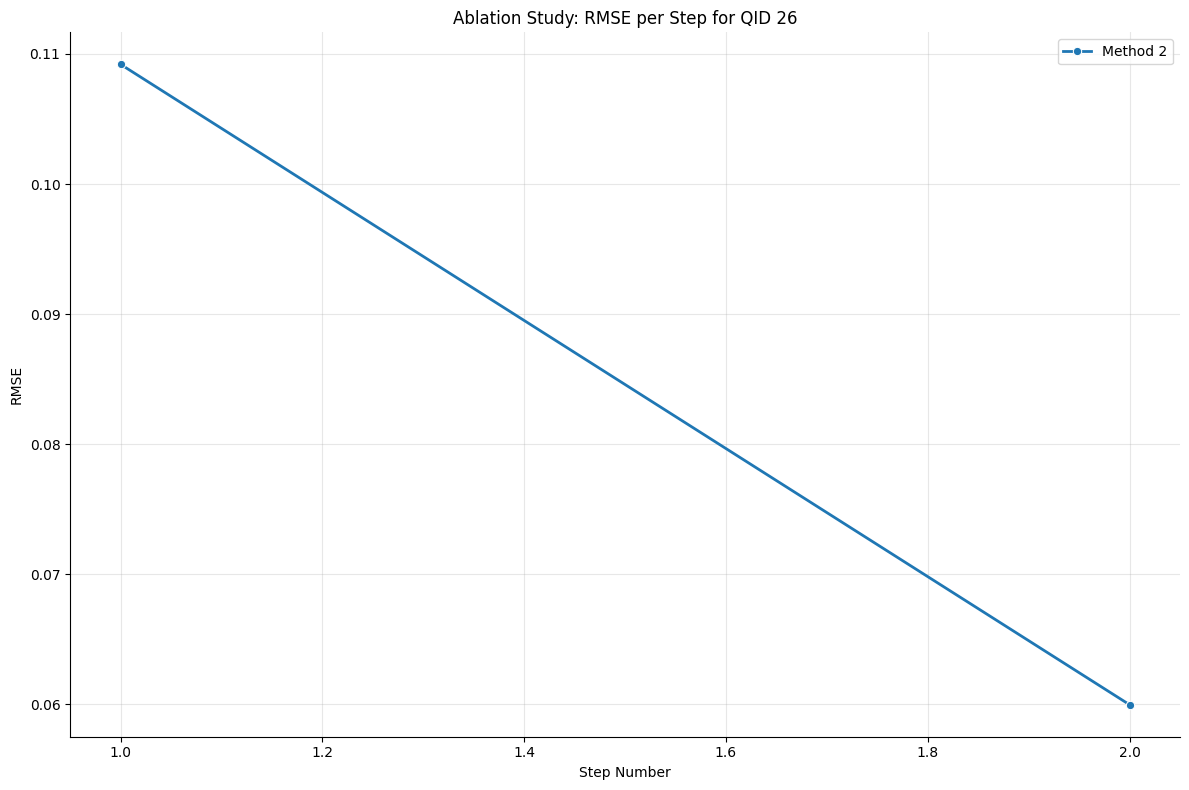


=== Cost Comparison ===
Found 2 steps for QID 26 in iterative_o4-mini.log
  Data sample: ('{\n    "cfl": 0.25,\n    "beta": 2.0,\n    "k": 0.0,\n    "n_space": 50\n  }', 0.109202, 5000)


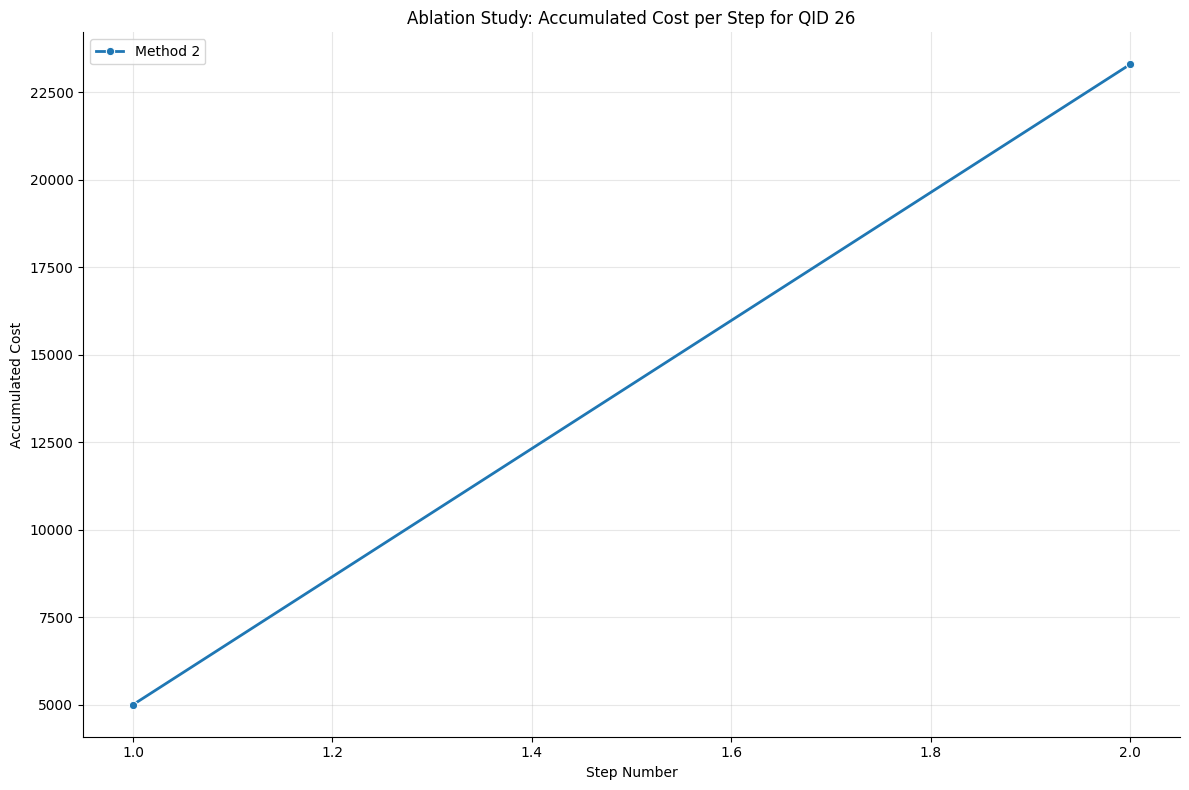

In [ ]:
# Test with both files and both metrics
test_file = "/home/ubuntu/dev/SimulCost-Bench/eval_results/euler_1d/n_space/low/iterative_ab_openai_init_refined_t05.log"
test_file_2 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/iterative_o4-mini.log"

print("=== RMSE Comparison ===")
plot_ablation_study_for_qid([test_file, test_file_2], qid=13, labels=["Method 1", "Method 2"], metric="rmse")

print("\n=== Cost Comparison ===")
plot_ablation_study_for_qid([test_file, test_file_2], qid=13, labels=["Method 1", "Method 2"], metric="cost")

In [13]:
def plot_rmse_and_cost_for_qid(file_paths: List[str], qid: int, tolerance_threshold: float, labels: List[str] = None):
    """
    Plot both RMSE and accumulated cost for a specific QID across different methods, with tolerance threshold.
    
    Args:
        file_paths: List of log file paths (each representing a different method)
        qid: QID number to plot (1-indexed)
        tolerance_threshold: Horizontal dotted line representing the tolerance threshold
        labels: Optional labels for each method (defaults to filename)
    """
    if labels is None:
        labels = [Path(fp).stem for fp in file_paths]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Colors for different methods
    colors = sns.color_palette("husl", len(file_paths))
    
    for file_idx, file_path in enumerate(file_paths):
        # Extract data for this file
        qid_data = extract_tool_call_data([file_path])
        
        # Check if the requested QID exists (convert to 0-indexed)
        qid_idx = qid - 1
        if qid_idx < len(qid_data) and qid_data[qid_idx]:
            qid_calls = qid_data[qid_idx]
            steps = list(range(1, len(qid_calls) + 1))
            
            # Extract RMSE and cost values
            rmse_values = [rmse for _, rmse, _ in qid_calls]
            cost_values = [cost for _, _, cost in qid_calls]
            
            print(f"Found {len(qid_calls)} steps for QID {qid} in {Path(file_path).name}")
            print(f"  Data sample: {qid_calls[0] if qid_calls else 'No data'}")
            
            # Plot RMSE
            ax1.plot(steps, rmse_values, marker='o', label=labels[file_idx], 
                    linewidth=2, markersize=6, color=colors[file_idx])
            
            # Plot Cost
            ax2.plot(steps, cost_values, marker='s', label=labels[file_idx], 
                    linewidth=2, markersize=6, color=colors[file_idx])
        else:
            print(f"Warning: QID {qid} not found in {file_path} (found {len(qid_data)} QIDs total)")
    
    # Add tolerance threshold line to RMSE plot
    if file_paths:  # Only add if we have data
        ax1.axhline(y=tolerance_threshold, color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f'Tolerance Threshold ({tolerance_threshold})')
    
    # Configure RMSE subplot
    ax1.set_xlabel('Step Number', fontsize=18)  # Increased from 14 to 18
    ax1.set_ylabel('RMSE', fontsize=18)  # Increased from 14 to 18
    ax1.set_title(f'RMSE per Step for QID {qid}', fontsize=20)  # Increased from 16 to 20
    ax1.legend(fontsize=14)  # Increased from 10 to 14
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=14)  # Increased from 10 to 14
    
    # Configure Cost subplot
    ax2.set_xlabel('Step Number', fontsize=18)  # Increased from 14 to 18
    ax2.set_ylabel('Accumulated Cost', fontsize=18)  # Increased from 14 to 18
    ax2.set_title(f'Accumulated Cost per Step for QID {qid}', fontsize=20)  # Increased from 16 to 20
    ax2.legend(fontsize=14)  # Increased from 10 to 14
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=14)  # Increased from 10 to 14
    
    # Apply seaborn styling
    sns.despine(ax=ax1)
    sns.despine(ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# file_paths = [
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method1.log",
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method2.log"
# ]
# plot_rmse_and_cost_for_qid(file_paths, qid=1, tolerance_threshold=0.05, labels=["Method1", "Method2"])

In [ ]:
# Test the new combined plotting function
test_file_2 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/iterative_o4-mini.log"

print("=== Combined RMSE and Cost Comparison with Tolerance Threshold ===")
plot_rmse_and_cost_for_qid([test_file, test_file_2], qid=1, tolerance_threshold=0.05, labels=["Method 1", "Method 2"])

In [14]:
def soft_success(d, epsilon):
    """计算单个 (d, epsilon) 对的 Soft Success 值"""
    r = d / epsilon
    
    if r <= 1:
        return 1.0
    
    # 参数
    alpha = 0.6
    beta = 0.43
    gamma = 1.5
    omega = 0.3
    delta = 2.2
    
    # 双组分衰减函数
    exp_component = np.exp(-beta * (r - 1)**gamma)
    logistic_component = 1 / (1 + omega * (r - 1)**delta)
    
    return alpha * exp_component + (1 - alpha) * logistic_component

def plot_rmse_and_cost_dual_axis(file_paths, qid: int, tolerance_threshold: float, labels = None):
    """
    Plot both RMSE and accumulated cost for a specific QID on the same plot with dual y-axes.
    
    Args:
        file_paths: List of log file paths (each representing a different method)
        qid: QID number to plot (1-indexed)
        tolerance_threshold: Horizontal dotted line representing the tolerance threshold for RMSE
        labels: Optional labels for each method (defaults to filename)
    """
    if labels is None:
        labels = [Path(fp).stem for fp in file_paths]
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Create second y-axis
    ax2 = ax1.twinx()
    
    # Colors for different methods
    colors = sns.color_palette("husl", len(file_paths))
    
    # Track all data to find overall max steps
    all_method_data = []
    max_steps = 0
    
    # First pass: extract all data and find max steps
    for file_idx, file_path in enumerate(file_paths):
        # Extract data for this file
        qid_data = extract_tool_call_data([file_path])
        
        # Check if the requested QID exists (convert to 0-indexed)
        qid_idx = qid - 1
        if qid_idx < len(qid_data) and qid_data[qid_idx]:
            qid_calls = qid_data[qid_idx]
            steps = list(range(1, len(qid_calls) + 1))
            
            # Extract RMSE and cost values
            rmse_values = [rmse for _, rmse, _ in qid_calls]
            cost_values = [cost for _, _, cost in qid_calls]
            
            method_data = {
                'steps': steps,
                'rmse_values': rmse_values,
                'cost_values': cost_values,
                'file_idx': file_idx,
                'label': labels[file_idx]
            }
            all_method_data.append(method_data)
            max_steps = max(max_steps, len(qid_calls))
            
            print(f"Found {len(qid_calls)} steps for QID {qid} in {Path(file_path).name}")
            print(f"  Data sample: {qid_calls[0] if qid_calls else 'No data'}")
        else:
            print(f"Warning: QID {qid} not found in {file_path} (found {len(qid_data)} QIDs total)")
    
    # Second pass: plot with horizontal extensions for shorter solutions
    for method_data in all_method_data:
        steps = method_data['steps']
        #rmse_values = method_data['rmse_values']
        rmse_values = [soft_success(r, 0.02) for r in method_data['rmse_values']]
        cost_values = method_data['cost_values']
        file_idx = method_data['file_idx']
        label = method_data['label']
        color = colors[file_idx]
        
        # Plot RMSE on left y-axis (solid line)
        ax1.plot(steps, rmse_values, marker='o', label=f'{label} (RMSE)', 
                linewidth=2, markersize=6, color=color, linestyle='-')
        
        # Plot Cost on right y-axis (dashed line, same color)
        ax2.plot(steps, cost_values, marker='s', label=f'{label} (Cost)', 
                linewidth=2, markersize=6, color=color, linestyle='--')
        
        # If this method has fewer steps than the maximum, extend with horizontal lines
        if len(steps) < max_steps:
            last_step = steps[-1]
            last_rmse = rmse_values[-1]
            last_cost = cost_values[-1]
            
            # Extend RMSE line horizontally to max_steps
            extension_steps = list(range(last_step + 1, max_steps + 1))
            extension_rmse = [last_rmse] * len(extension_steps)
            extension_cost = [last_cost] * len(extension_steps)
            
            # Plot horizontal extensions (same color, but with different line style for distinction)
            ax1.plot(extension_steps, extension_rmse, 
                    color=color, linestyle='-', linewidth=2, alpha=0.7)
            ax2.plot(extension_steps, extension_cost, 
                    color=color, linestyle='--', linewidth=2, alpha=0.7)
    
    # Add tolerance threshold line to RMSE (left axis)
    if file_paths:  # Only add if we have data
        ax1.axhline(y=tolerance_threshold, color='red', linestyle=':', 
                   linewidth=2, alpha=0.8, label=f'Tolerance ({tolerance_threshold})')
    
    # Configure left y-axis (RMSE)
    ax1.set_xlabel('Step Number')
    ax1.set_ylabel('RMSE', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)
    
    # Configure right y-axis (Cost)
    ax2.set_ylabel('Accumulated Cost', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title(f'RMSE and Accumulated Cost per Step for QID {qid}')
    sns.despine(ax=ax1)
    sns.despine(ax=ax2, right=False)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# file_paths = [
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method1.log",
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method2.log"
# ]
# plot_rmse_and_cost_dual_axis(file_paths, qid=1, tolerance_threshold=0.05, labels=["Method1", "Method2"])

=== Dual-Axis RMSE and Cost Comparison ===
Found 3 steps for QID 13 in iterative_ab_openai_surrogate.log
  Data sample: ("{'n_space': 2400, 'cfl': 0.25, 'beta': 1.5, 'k': -1.0}", 0.024026, 13015200)
Found 2 steps for QID 13 in iterative_ab_openai_numerical.log
  Data sample: ("{'n_space': 2048, 'cfl': 0.25, 'beta': 1.5, 'k': -1.0}", 0.02582, 9482240)
Found 1 steps for QID 13 in iterative_o4-mini.log
  Data sample: ('{"cfl": 0.25,"beta": 1.5,"k": -1.0,"n_space": 4096\n}', 0.01898, 38659200)


NameError: name 'np' is not defined

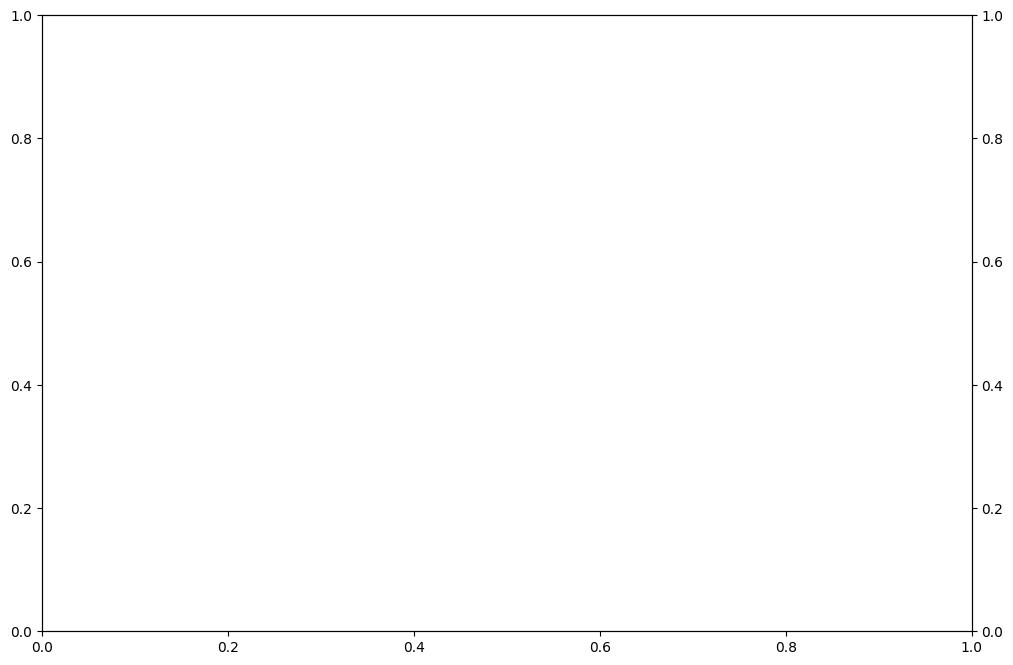

In [15]:
# Test the dual-axis plotting function
test_file = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_surrogate.log"
test_file_2 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_numerical.log"
test_file_3 = "/home/ubuntu/dev/SimulCost-Bench/eval_results/euler_1d/n_space/medium/iterative_o4-mini.log"

print("=== Dual-Axis RMSE and Cost Comparison ===")
plot_rmse_and_cost_dual_axis([test_file, test_file_2, test_file_3], qid=13, tolerance_threshold=0.02, labels=["o4-mini Ours w/ Physics Prior", "o4-mini Ours w/o Physics Prior", "o4-mini Direct Prompting w/ Physics Prior"])

In [26]:
import re
import json
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict

def soft_success(d, epsilon):
    """计算单个 (d, epsilon) 对的 Soft Success 值"""
    r = d / epsilon
    
    if r <= 1:
        return 1.0
    
    # 参数
    alpha = 0.6
    beta = 0.43
    gamma = 1.5
    omega = 0.3
    delta = 2.2
    
    # 双组分衰减函数
    exp_component = np.exp(-beta * (r - 1)**gamma)
    logistic_component = 1 / (1 + omega * (r - 1)**delta)
    
    return alpha * exp_component + (1 - alpha) * logistic_component

def extract_tool_call_data(file_paths: List[str]) -> List[List[Tuple[str, float, int]]]:
    """
    Extract tool call data from log files.
    
    Args:
        file_paths: List of log file paths
        
    Returns:
        List of lists, where each inner list contains (tool_args, RMSE, accumulated_cost) tuples for each QID
    """
    all_qid_data = []
    
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            content = f.read()
        
        # Detect file format and extract accordingly
        if '🆔 QID:' in content and '📉 RMSE (model vs. dummy):' in content:
            # Evaluation results format
            qid_data = extract_evaluation_format(content)
        else:
            # Tool call log format
            qid_data = extract_tool_call_format(content)
        
        all_qid_data.extend(qid_data)
    
    return all_qid_data

def extract_evaluation_format(content: str) -> List[List[Tuple[str, float, int]]]:
    """Extract data from evaluation results format."""
    qid_blocks = re.split(r'📊 --- Evaluation Result ---', content)
    qid_data = []
    
    for block in qid_blocks[1:]:  # Skip first empty block
        # Extract QID
        qid_match = re.search(r'🆔 QID:\s*(\d+)', block)
        if not qid_match:
            continue
            
        # Extract RMSE
        rmse_match = re.search(r'📉 RMSE \(model vs\. dummy\):\s*([0-9.e-]+)', block)
        rmse = float(rmse_match.group(1)) if rmse_match else 0.0
        
        # Extract Model Cost
        cost_match = re.search(r'💰 Model Cost:\s*(\d+)', block)
        cost = int(cost_match.group(1)) if cost_match else 0
        
        # Extract Model Parameters
        param_match = re.search(r'📌 Model Parameters:\s*\{([^}]*)\}', block, re.DOTALL)
        if param_match:
            param_str = '{' + param_match.group(1) + '}'
            # Clean up the parameter string format
            param_str = re.sub(r'\s*"([^"]+)":\s*([^,\n}]+)', r'"\1": \2', param_str)
            tool_args = param_str
        else:
            tool_args = "N/A"
        
        # Each evaluation result represents a single "step" for this QID
        qid_data.append([(tool_args, rmse, cost)])
    
    return qid_data

def extract_tool_call_format(content: str) -> List[List[Tuple[str, float, int]]]:
    """Extract data from tool call log format."""
    qid_data = []
    
    # Split by QID sections
    qid_sections = re.split(r'========== 🧐 The model begins to solve a new problem ==========', content)
    
    for section in qid_sections[1:]:  # Skip first empty section
        qid_tool_calls = []
        
        # Find all tool calls and their results in this QID using a more flexible approach
        # Split by tool call blocks
        tool_call_blocks = re.findall(
            r'QID=(\d+) - 🛠 Received tool call: \{(.*?)\}(?=\n\[INFO|\nQID|\Z)', 
            section, 
            re.DOTALL
        )
        
        # Find RMSE and accumulated_cost from results
        result_blocks = re.findall(
            r'QID=\d+ - ✅ Tool call result: \{(.*?)\}(?=\n\[INFO|\nQID|\Z)', 
            section, 
            re.DOTALL
        )
        
        # Process each tool call block
        for i, (qid, tool_call_content) in enumerate(tool_call_blocks):
            if i < len(result_blocks):
                result_content = result_blocks[i]
                
                # Extract RMSE
                rmse_match = re.search(r'"RMSE":\s*([0-9.]+)', result_content)
                rmse = float(rmse_match.group(1)) if rmse_match else 0.0
                
                # Extract accumulated_cost
                cost_match = re.search(r'"accumulated_cost":\s*([0-9]+)', result_content)
                accumulated_cost = int(cost_match.group(1)) if cost_match else 0
                
                # Extract tool_args - handle both string and JSON object formats
                tool_args = "N/A"  # Default value
                
                # Try to find tool_args as a string (format 1)
                string_match = re.search(r'"tool_args":\s*"([^"]*)"', tool_call_content)
                if string_match:
                    tool_args = string_match.group(1)
                else:
                    # Try to find tool_args as a JSON object (format 2)
                    json_match = re.search(r'"tool_args":\s*(\{[^}]*\})', tool_call_content)
                    if json_match:
                        tool_args = json_match.group(1)
                
                qid_tool_calls.append((tool_args, rmse, accumulated_cost))
        
        if qid_tool_calls:
            qid_data.append(qid_tool_calls)
    
    return qid_data

def plot_rmse_and_cost_dual_axis(file_paths: List[str], qid: int, tolerance_threshold: float, labels: List[str] = None):
    """
    Plot both RMSE and accumulated cost for a specific QID on the same plot with dual y-axes.
    
    Args:
        file_paths: List of log file paths (each representing a different method)
        qid: QID number to plot (1-indexed)
        tolerance_threshold: Horizontal dotted line representing the tolerance threshold for RMSE
        labels: Optional labels for each method (defaults to filename)
    """
    if labels is None:
        labels = [Path(fp).stem for fp in file_paths]
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Create second y-axis
    ax2 = ax1.twinx()
    
    # Colors for different methods
    colors = sns.color_palette("husl", len(file_paths))
    
    # Track all data to find overall max steps
    all_method_data = []
    max_steps = 0
    
    # First pass: extract all data and find max steps
    for file_idx, file_path in enumerate(file_paths):
        # Extract data for this file
        qid_data = extract_tool_call_data([file_path])
        
        # Check if the requested QID exists (convert to 0-indexed)
        qid_idx = qid - 1
        if qid_idx < len(qid_data) and qid_data[qid_idx]:
            qid_calls = qid_data[qid_idx]
            steps = list(range(1, len(qid_calls) + 1))
            
            # Extract RMSE and cost values
            rmse_values = [rmse for _, rmse, _ in qid_calls]
            cost_values = [cost for _, _, cost in qid_calls]
            
            method_data = {
                'steps': steps,
                'rmse_values': rmse_values,
                'cost_values': cost_values,
                'file_idx': file_idx,
                'label': labels[file_idx]
            }
            all_method_data.append(method_data)
            max_steps = max(max_steps, len(qid_calls))
            
            print(f"Found {len(qid_calls)} steps for QID {qid} in {Path(file_path).name}")
            print(f"  Data sample: {qid_calls[0] if qid_calls else 'No data'}")
        else:
            print(f"Warning: QID {qid} not found in {file_path} (found {len(qid_data)} QIDs total)")
    
    # Store line objects for custom legend
    legend_lines = []
    legend_labels = []
    
    # Second pass: plot with horizontal extensions for shorter solutions
    for method_data in all_method_data:
        steps = method_data['steps']
        #rmse_values = [soft_success(r, 0.02) for r in method_data['rmse_values']]
        rmse_values = method_data['rmse_values']
        cost_values = method_data['cost_values']
        file_idx = method_data['file_idx']
        label = method_data['label']
        color = colors[file_idx]
        
        # Plot RMSE on left y-axis (solid line)
        rmse_line = ax1.plot(steps, rmse_values, marker='o', 
                            linewidth=2, markersize=6, color=color, linestyle='-')[0]
        
        # Plot Cost on right y-axis (dashed line, same color)
        cost_line = ax2.plot(steps, cost_values, marker='s', 
                            linewidth=2, markersize=6, color=color, linestyle='--')[0]
        
        # Add to legend with proper line styles
        legend_lines.extend([rmse_line, cost_line])
        legend_labels.extend([f'{label} (RMSE)', f'{label} (Cost)'])
        
        # If this method has fewer steps than the maximum, extend with horizontal lines
        if len(steps) < max_steps:
            last_step = steps[-1]
            last_rmse = rmse_values[-1]
            last_cost = cost_values[-1]
            
            # Create horizontal extension from last step to max_steps
            extension_steps = [last_step, max_steps]
            extension_rmse = [last_rmse, last_rmse]
            extension_cost = [last_cost, last_cost]
            
            # Plot horizontal extensions (connecting line from last point to end)
            ax1.plot(extension_steps, extension_rmse, 
                    color=color, linestyle='-', linewidth=2, alpha=0.7)
            ax2.plot(extension_steps, extension_cost, 
                    color=color, linestyle='--', linewidth=2, alpha=0.7)
            
            # Add markers at the final step to show where the solution stopped extending
            ax1.plot(max_steps, last_rmse, marker='o', 
                    color=color, markersize=6, alpha=0.7)
            ax2.plot(max_steps, last_cost, marker='s', 
                    color=color, markersize=6, alpha=0.7)
    
    # Add tolerance threshold line to RMSE (left axis)
    if file_paths:  # Only add if we have data
        tolerance_line = ax1.axhline(y=tolerance_threshold, color='red', linestyle=':', 
                                   linewidth=2, alpha=0.8)
        legend_lines.append(tolerance_line)
        legend_labels.append(f'Success Threshold ({tolerance_threshold})')
    
    # Configure left y-axis (RMSE)
    ax1.set_xlabel('Step Number', fontsize=18)  # Increased from 14 to 18
    ax1.set_ylabel('Soft Success Score', fontsize=18, color='black')  # Increased from 14 to 18
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)  # Increased from 10 to 14
    ax1.tick_params(axis='x', labelsize=14)  # Increased from 10 to 14
    ax1.grid(True, alpha=0.3)
    
    # Configure right y-axis (Cost)
    ax2.set_ylabel('Accumulated Cost', fontsize=18, color='black')  # Increased from 14 to 18
    ax2.tick_params(axis='y', labelcolor='black', labelsize=14)  # Increased from 10 to 14
    
    # Create custom legend that preserves line styles
    ax1.legend(legend_lines, legend_labels, loc='best', fontsize=14)  # Increased from 10 to 14
    
    plt.title(f'Iterative Optimization Process', fontsize=20)  # Increased from 16 to 20
    sns.despine(ax=ax1)
    sns.despine(ax=ax2, right=False)
    
    plt.tight_layout()
    plt.show()

In [27]:
def plot_cost_vs_rmse_trajectory(file_paths: List[str], qid: int, tolerance_threshold: float, labels: List[str] = None, name = None):
    """
    Plot cost vs RMSE trajectory for a specific QID across different methods.
    Uses points and arrows to show the optimization progression.

    Args:
        file_paths: List of log file paths (each representing a different method)
        qid: QID number to plot (1-indexed)
        tolerance_threshold: Horizontal dotted line representing the tolerance threshold for RMSE
        labels: Optional labels for each method (defaults to filename)
    """
    # MPM-style plotting configuration
    label_font = 58
    markersize = 20  # reduced from 36 to 20
    tick_font = 58
    line_width = 3.6
    markers = ["o", "s", "v", "D", "h", "H", "d", "*"]
    colors = [
        "#0072BD",
        "#D95319",
        "#EDB120",
        "#7E2F8E",
        "#77AC30",
        "#4DBEEE",
        "#A2142F",
        "#000000",
    ]

    if labels is None:
        labels = [Path(fp).stem for fp in file_paths]

    # Create figure with MPM-style dimensions (20% taller)
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))

    for file_idx, file_path in enumerate(file_paths):
        # Extract data for this file
        qid_data = extract_tool_call_data([file_path])

        # Check if the requested QID exists (convert to 0-indexed)
        qid_idx = qid - 1
        if qid_idx < len(qid_data) and qid_data[qid_idx]:
            qid_calls = qid_data[qid_idx]

            # Extract RMSE and cost values
            rmse_values = [rmse for _, rmse, _ in qid_calls]
            cost_values = [cost for _, _, cost in qid_calls]

            # Use MPM-style colors and markers
            color = colors[file_idx % len(colors)]
            marker = markers[file_idx % len(markers)]

            print(f"Found {len(qid_calls)} steps for QID {qid} in {Path(file_path).name}")
            print(f"  Data sample: {qid_calls[0] if qid_calls else 'No data'}")

            # Plot points for each step (show all points) with MPM styling
            ax.scatter(cost_values, rmse_values, c=[color]*len(cost_values), 
                      marker=marker, s=markersize*4, alpha=0.7, label=labels[file_idx], 
                      edgecolors='black', linewidths=1.2)

            # Add step numbers as annotations with MPM font size
            for i, (cost, rmse) in enumerate(zip(cost_values, rmse_values)):
                ax.annotate(str(i+1), (cost, rmse), 
                           textcoords="offset points", xytext=(5, 5), 
                           ha='left', va='bottom', fontsize=label_font//3,
                           color=color, fontweight='bold')

            # Mark starting point with a special symbol using MPM styling
            if cost_values and rmse_values:
                ax.scatter(cost_values[0], rmse_values[0], c='white', 
                          marker=marker, s=markersize*5, edgecolors=color, linewidths=3,
                          zorder=10)
                ax.annotate('START', (cost_values[0], rmse_values[0]), 
                           textcoords="offset points", xytext=(0, -15), 
                           ha='center', va='top', fontsize=label_font//3,
                           color=color, fontweight='bold')
        else:
            print(f"Warning: QID {qid} not found in {file_path} (found {len(qid_data)} QIDs total)")

    # Add tolerance threshold line with MPM styling
    ax.axhline(y=tolerance_threshold, color='red', linestyle='--', 
               linewidth=line_width, alpha=0.8, label=f'RMSE Threshold ({tolerance_threshold})')

    # Apply MPM-style formatting
    ax.tick_params(
        top=False,
        bottom=True,
        left=True,
        right=False,
        labelleft=True,
        labelsize=tick_font,
    )
    ax.xaxis.offsetText.set_fontsize(label_font)
    ax.get_xaxis().set_visible(True)
    ax.set_xlabel('Accumulated Cost', fontsize=label_font)
    ax.set_ylabel('RMSE', fontsize=label_font)
    ax.grid(True, linestyle="--", linewidth=line_width / 2)

    # Use original y-axis limits (like the original code)
    y_max = 2 * tolerance_threshold
    current_ylim = ax.get_ylim()
    ax.set_ylim(max(current_ylim[0], 0.5 * tolerance_threshold), min(y_max, current_ylim[1]))

    # Add arrows only between consecutive points that are both within the plot bounds
    for file_idx, file_path in enumerate(file_paths):
        qid_data = extract_tool_call_data([file_path])
        qid_idx = qid - 1
        if qid_idx < len(qid_data) and qid_data[qid_idx]:
            qid_calls = qid_data[qid_idx]
            rmse_values = [rmse for _, rmse, _ in qid_calls]
            cost_values = [cost for _, _, cost in qid_calls]
            color = colors[file_idx % len(colors)]

            # Get current axis limits
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()

            # Add arrows only between consecutive steps that are both visible
            for i in range(len(cost_values) - 1):
                x1, y1 = cost_values[i], rmse_values[i]
                x2, y2 = cost_values[i+1], rmse_values[i+1]

                # Check if both points are within the visible area
                if (xlim[0] <= x1 <= xlim[1] and ylim[0] <= y1 <= ylim[1] and
                    xlim[0] <= x2 <= xlim[1] and ylim[0] <= y2 <= ylim[1]):
                    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                               arrowprops=dict(arrowstyle='->', color=color, lw=line_width/2, alpha=0.6))

    # MPM-style legend
    ax.legend(loc='upper right', fontsize=label_font//2)

    # Save with MPM settings
    plt.savefig(name, transparent=False, dpi=300, bbox_inches="tight", format="pdf")
    plt.show()

# Example usage:
# file_paths = [
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method1.log",
#     "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/low/n_space/method2.log"
# ]
# plot_cost_vs_rmse_trajectory(file_paths, qid=1, tolerance_threshold=0.05, labels=["Method1", "Method2"])

=== Cost vs RMSE Trajectory Visualization ===
Found 2 steps for QID 16 in iterative_ab_openai_init_refined_t05.log
  Data sample: ("{'n_space': 1536, 'cfl': 0.25, 'beta': 2.0, 'k': 0.0}", 0.020796, 5334528)
Found 1 steps for QID 16 in iterative_ab_openai_numerical.log
  Data sample: ("{'n_space': 2000, 'cfl': 0.25, 'beta': 2.0, 'k': 0.0}", 0.018559, 39040000)
Found 7 steps for QID 16 in iterative_o4-mini.log
  Data sample: ('{\n    "cfl": 0.25,\n    "beta": 2.0,\n    "k": -1.0,\n    "n_space": 64\n  }', 0.11978, 9600)


<Figure size 1920x1440 with 0 Axes>

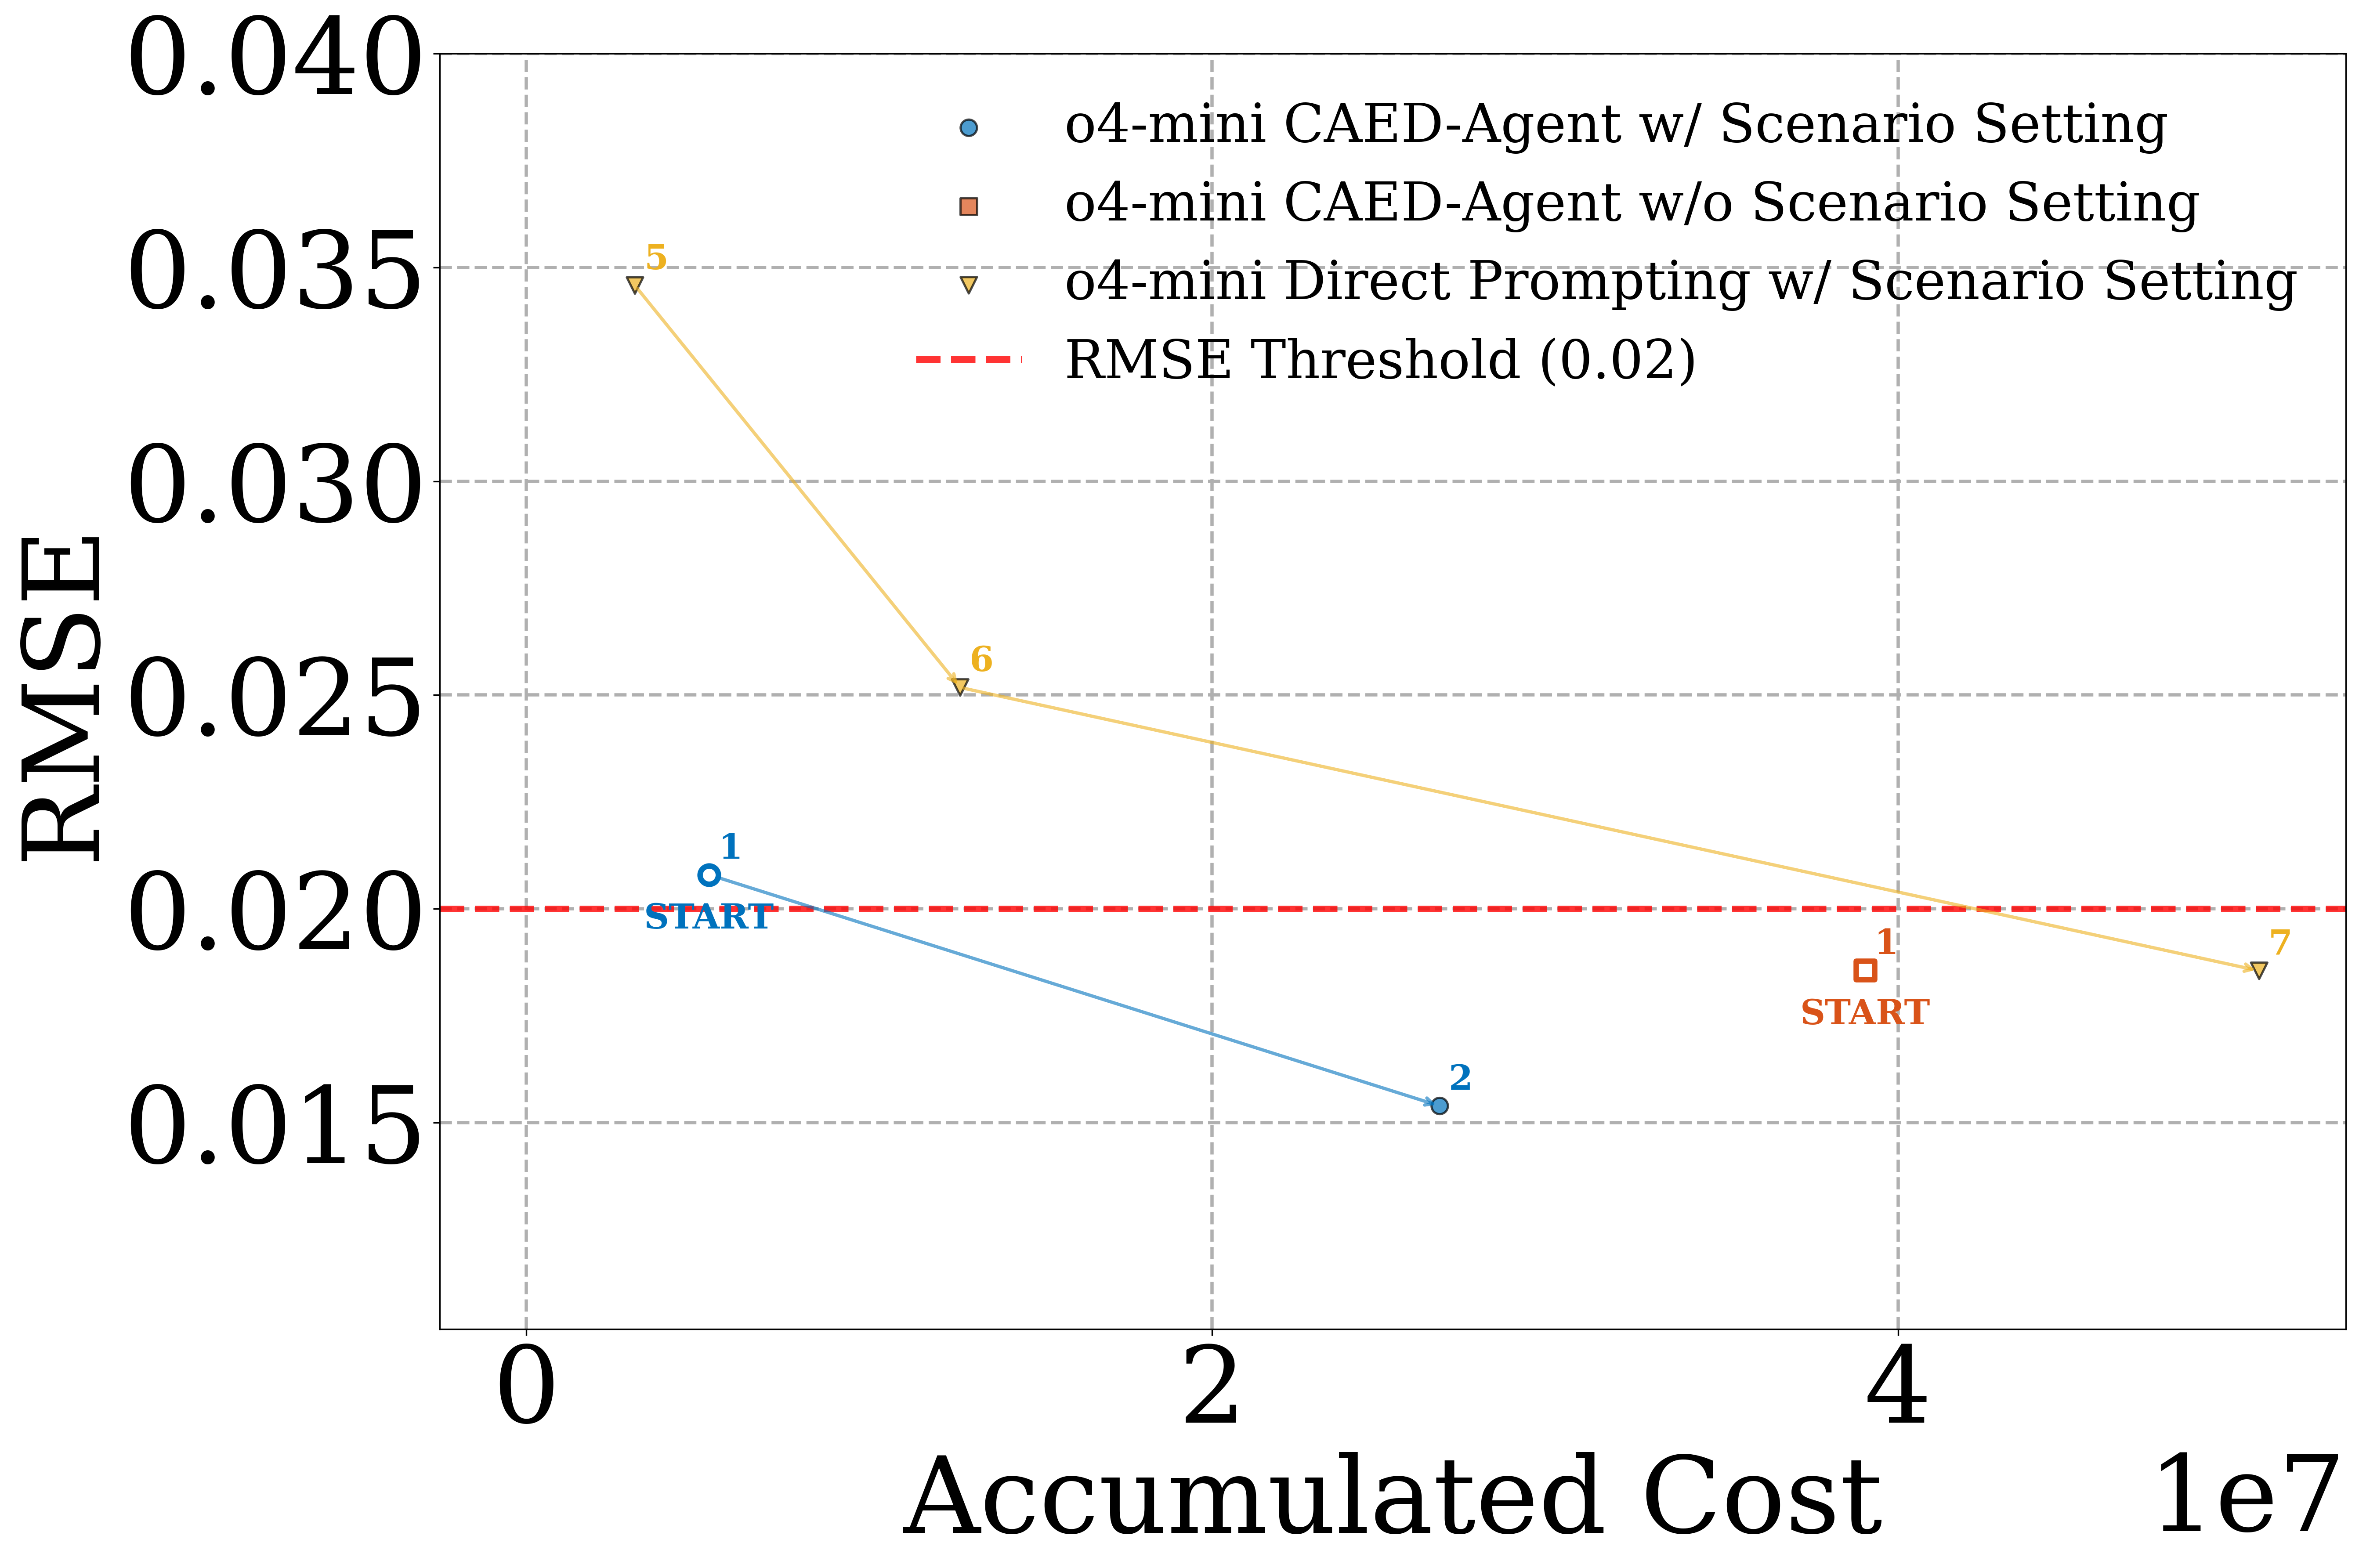

Found 2 steps for QID 16 in iterative_ab_openai_init_refined_t05.log
  Data sample: ("{'n_space': 1536, 'cfl': 0.25, 'beta': 2.0, 'k': 0.0}", 0.020796, 5334528)
Found 1 steps for QID 16 in iterative_ab_openai_random.log
  Data sample: ("{'n_space': 8192, 'cfl': 0.25, 'beta': 2.0, 'k': 0.0}", 0.013677, 37855232)
Found 7 steps for QID 16 in iterative_o4-mini.log
  Data sample: ('{\n    "cfl": 0.25,\n    "beta": 2.0,\n    "k": -1.0,\n    "n_space": 64\n  }', 0.11978, 9600)
Found 1 steps for QID 16 in iterative_ab_openai_hard.log
  Data sample: ("{'n_space': 3600, 'cfl': 0.25, 'beta': 2.0, 'k': 0.0}", 0.014412, 29246400)
Found 2 steps for QID 16 in iterative_ab_openai_icl.log
  Data sample: ("{'n_space': 1024, 'cfl': 0.25, 'beta': 2.0, 'k': 0.0}", 0.024982, 2375680)


<Figure size 1920x1440 with 0 Axes>

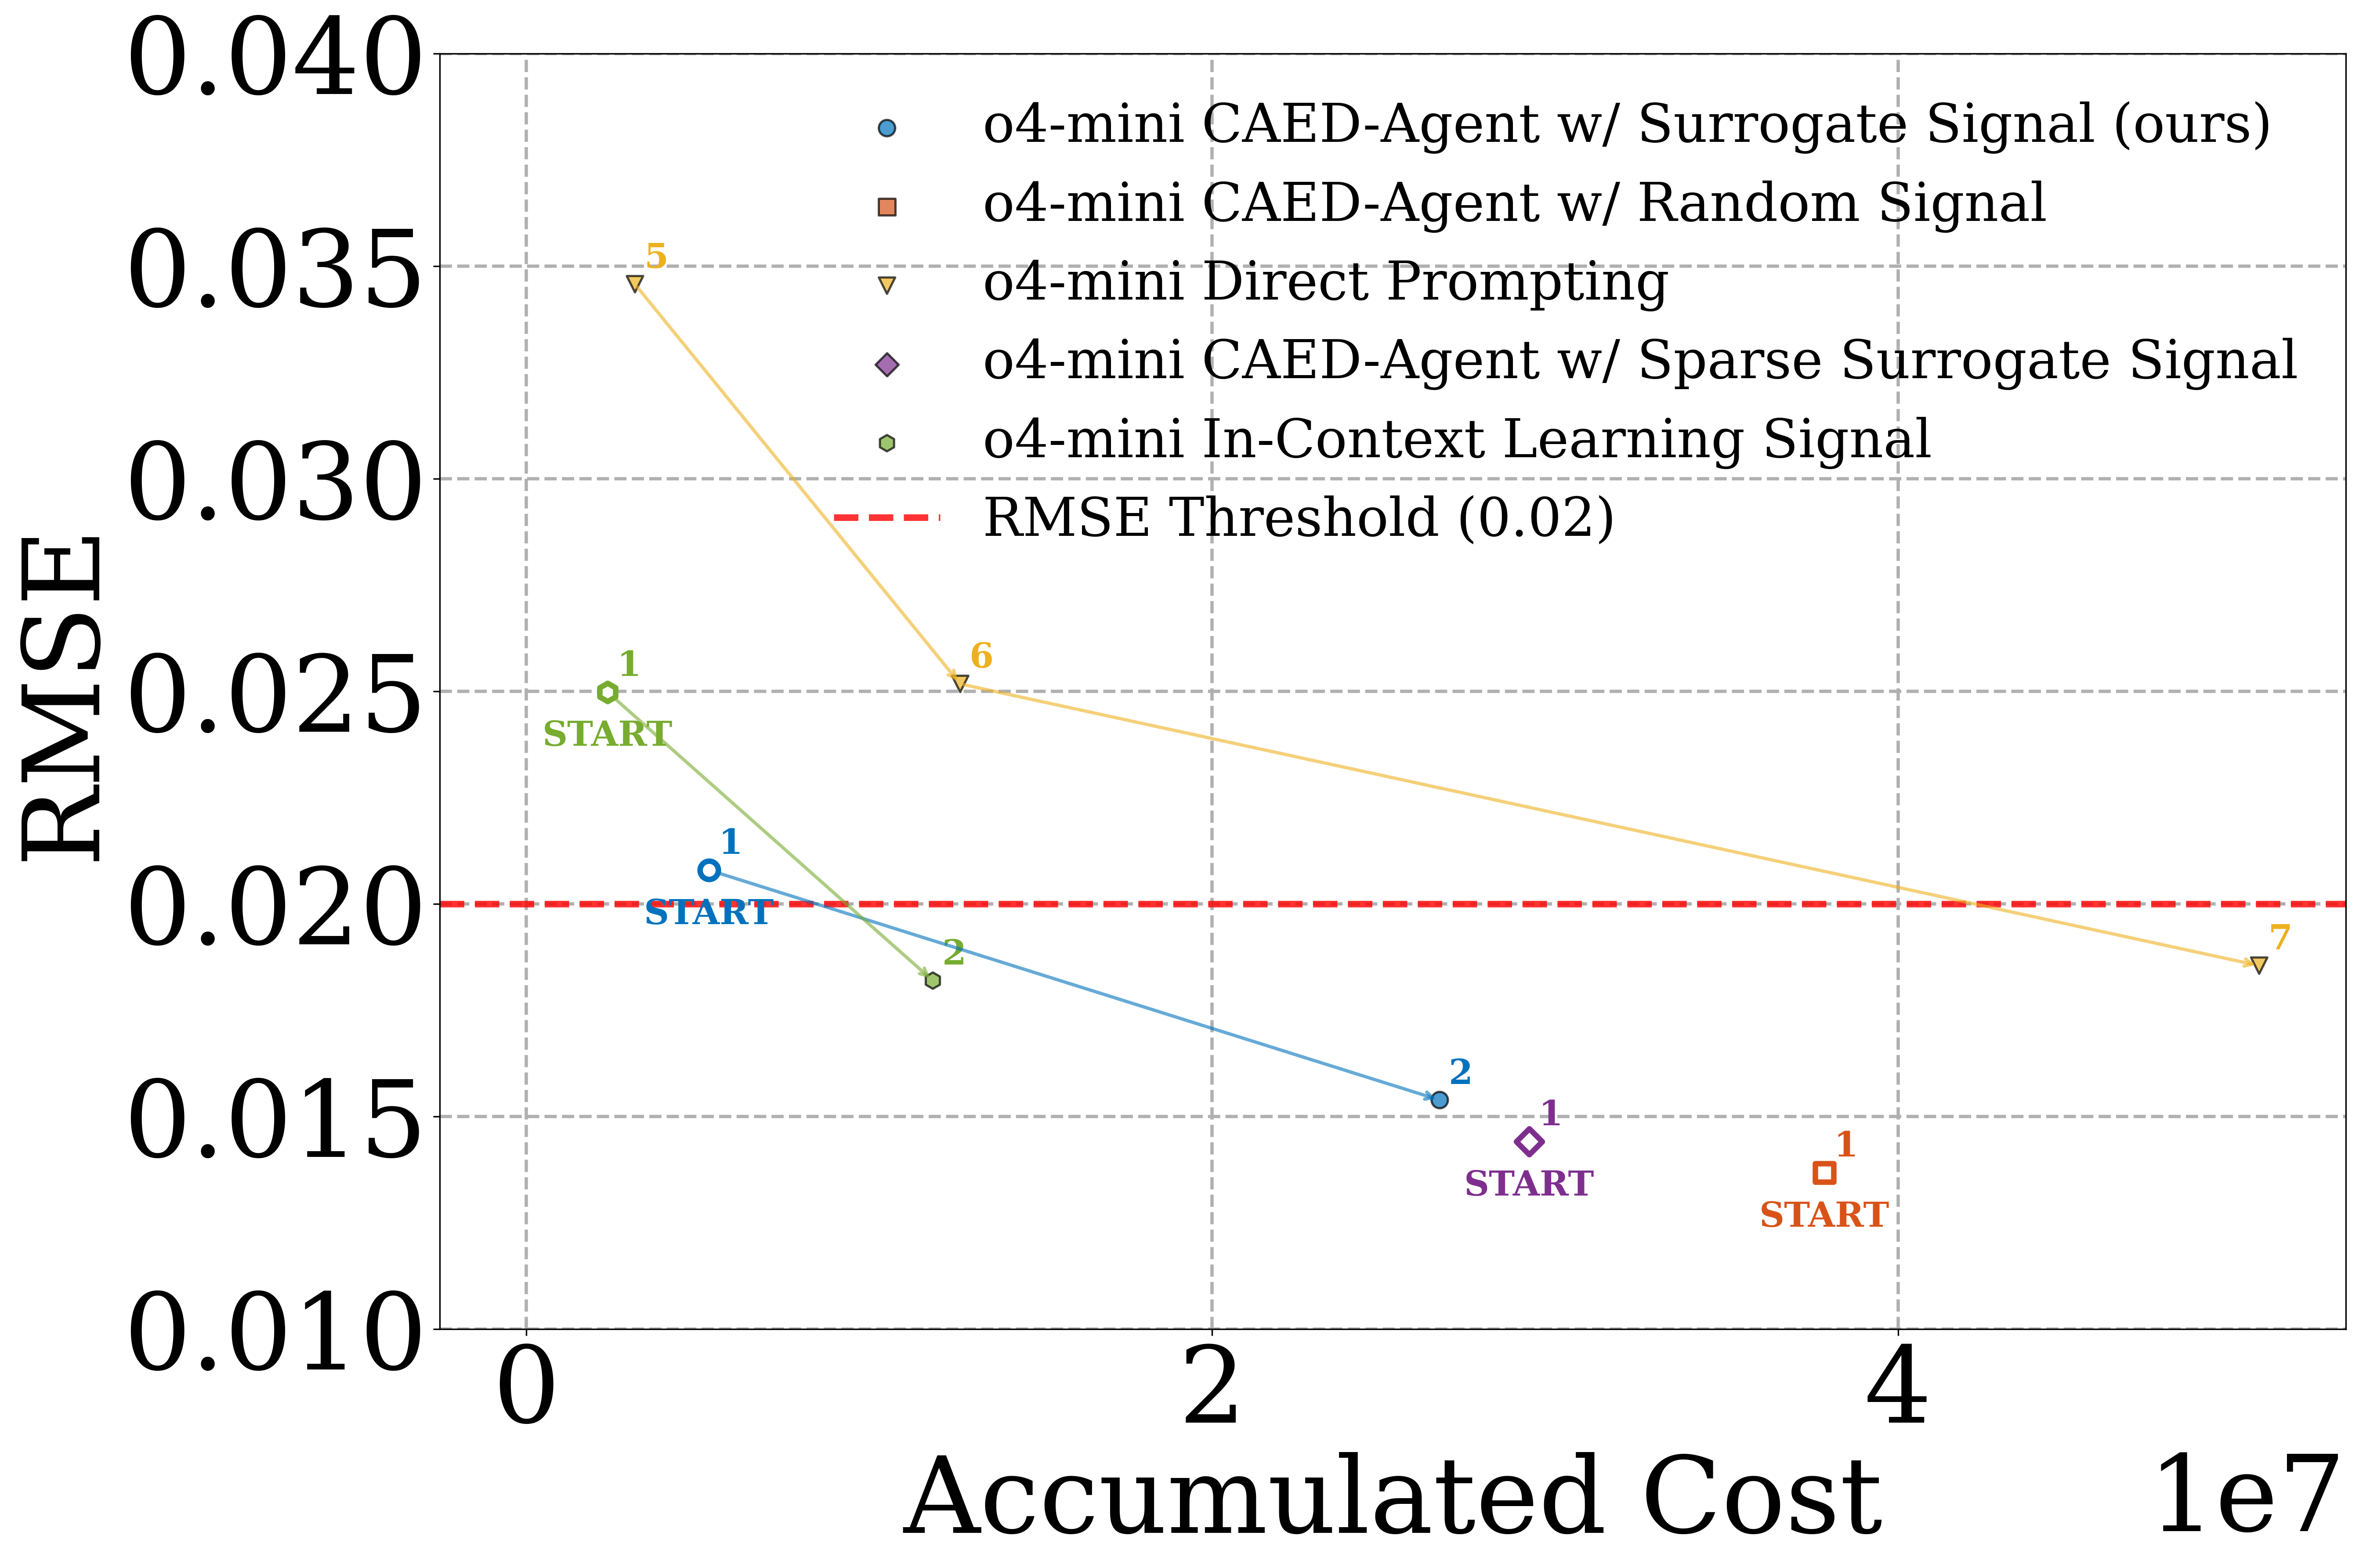

In [ ]:
# Test the new cost vs RMSE trajectory visualization
test_file = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_init_refined_t05.log"
test_file_2 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_numerical.log"
test_file_3 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_o4-mini.log"

print("=== Cost vs RMSE Trajectory Visualization ===")
plot_cost_vs_rmse_trajectory([test_file, test_file_2, test_file_3], qid=12, tolerance_threshold=0.02, 
                             labels=["o4-mini CAED-Agent w/ Scenario Setting",
                                     "o4-mini CAED-Agent w/o Scenario Setting",
                                     "o4-mini Direct Prompting w/ Scenario Setting"],
                             name="/home/ubuntu/dev/src/figures/ab-model-2.pdf")
                            
surrogate_file_1 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_init_refined_t05.log"
surrogate_file_2 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_random.log"
surrogate_file_3 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_o4-mini.log"
surrogate_file_4 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_hard.log"
surrogate_file_5 = "/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_ab_openai_icl.log"

plot_cost_vs_rmse_trajectory([surrogate_file_1, surrogate_file_2, surrogate_file_3, surrogate_file_4, surrogate_file_5], qid=12, tolerance_threshold=0.02,
                             labels=["o4-mini CAED-Agent w/ Surrogate Signal (ours)",
                                     "o4-mini CAED-Agent w/ Random Signal",
                                     "o4-mini Direct Prompting",
                                     "o4-mini CAED-Agent w/ Sparse Surrogate Signal",
                                     "o4-mini In-Context Learning Signal"],
                             name="/home/ubuntu/dev/src/figures/ab-surrogate-2.pdf")
